# Import necessary libraries

In [328]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from scipy import stats
import os
import glob
import math
sns.set_style("dark")
pd.options.mode.chained_assignment = None  # default='warn'

# Importing dataframes

## Defining cleaning functions

In [329]:
def item_header_clean(df):
    column_map = {
    "index" : "League",
    "League": "Date",
    "Date": "Id",
    "Id" : "Type"
    }
    df_indexreset = df.reset_index()
    df_renamed = df_indexreset.rename(columns = column_map)
    return df_renamed

def item_info_fix(df):
    cols_to_drop = ["Links", "Variant"]
    df_cols_dropped = df.drop(cols_to_drop, axis = 1)
    df_cols_dropped.BaseType = df_cols_dropped.BaseType.fillna(df_cols_dropped.Type)
    df_fixed = df_cols_dropped
    return df_fixed

def item_top_40_filter(df):
    median_series = df.groupby("Name")["Value"].agg("median")
    sorted_series = median_series.sort_values(ascending = False)
    top_40_list = list(sorted_series[:40].index)
    df_top_40 = df.loc[df["Name"].isin(top_40_list)]
    return df_top_40

def add_relative_date(df):
    df_copy = df
    df_copy["Date"] = df_copy["Date"].astype('datetime64[D]')
    startdate = df_copy["Date"].min()
    df_copy["RelativeDate"] = (df_copy["Date"] - startdate)
    df_edited = df_copy.drop("Date", axis = 1)
    df_edited["RelativeDate"] = pd.to_timedelta(df_edited["RelativeDate"], unit = "D")
    df_edited["RelativeDateInt"] = df_edited["RelativeDate"] / np.timedelta64(1, 'D')
    return df_edited

def league_lifespan(row):
    early_league = dt.timedelta(days = 14)
    mid_league = dt.timedelta(days = 60)
    if row["RelativeDate"] <= early_league:
        return "Early"
    elif row["RelativeDate"] <= mid_league:
        return "Mid"
    return "End"

def item_file_clean(df):
    df1 = item_header_clean(df)
    df2 = item_info_fix(df1)
    df3 = item_top_40_filter(df2)
    df4 = add_relative_date(df3)
    df4["League Lifespan"] = df4.apply(league_lifespan, axis = 1)
    return df4

def currency_info_fix(df):
    currency_to_drop = ["Portal Scroll", "Scroll of Wisdom", "Armourer's Scrap", "Perandus Coin", "Orb of Transmutation", "Blacksmith's Whetstone", "Orb of Augmentation", "Orb of Alteration", "Splinter of Tul", "Chromatic Orb", "Splinter of Esh", "Splinter of Xoph", "Orb of Chance", "Glassblower's Bauble", "Splinter of Uul-Netol", "Silver Coin"]
    df_currency_fixed = df.loc[~(df["Get"].isin(currency_to_drop) | df["Pay"].isin(currency_to_drop))]
    return df_currency_fixed

def currency_file_clean(df):
    df1 = currency_info_fix(df)
    df2 = add_relative_date(df1)
    df2["League Lifespan"] = df2.apply(league_lifespan, axis = 1)
    return df2

## File Import and Concatenation

In [330]:
# Import/Concatenate item files
item_df_list = []
for filename in glob.glob("*_items.csv"):
    df = pd.read_csv(filename, delimiter = ";", low_memory = False)
    df_edited = item_file_clean(df)
    item_df_list.append(df_edited)
item_df = pd.concat(item_df_list, axis = 0)
del item_df_list
item_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21009 entries, 11926 to 226813
Data columns (total 10 columns):
League             21009 non-null object
Id                 21009 non-null int64
Type               21009 non-null object
Name               21009 non-null object
BaseType           21009 non-null object
Value              21009 non-null float64
Confidence         21009 non-null object
RelativeDate       21009 non-null timedelta64[ns]
RelativeDateInt    21009 non-null float64
League Lifespan    21009 non-null object
dtypes: float64(2), int64(1), object(6), timedelta64[ns](1)
memory usage: 1.8+ MB


In [331]:
#Import/Concatenate currency files
currency_df_list = []
for filename in glob.glob("*_currency.csv"):
    df = pd.read_csv(filename, delimiter = ";", low_memory = False)
    df_edited = currency_file_clean(df)
    currency_df_list.append(df_edited)
currency_df = pd.concat(currency_df_list, axis = 0)
del currency_df_list
currency_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38885 entries, 356 to 9466
Data columns (total 8 columns):
League             38885 non-null object
Get                38885 non-null object
Pay                38885 non-null object
Value              38885 non-null float64
Confidence         38885 non-null object
RelativeDate       38885 non-null timedelta64[ns]
RelativeDateInt    38885 non-null float64
League Lifespan    38885 non-null object
dtypes: float64(2), object(5), timedelta64[ns](1)
memory usage: 2.7+ MB


## Paring down item table to only include items common across all leagues

In [332]:
def common_items(df):
    unique_items = []
    for league in df.League.unique():
        league_df = df[df.League == league]
        unique_items.append(league_df.Name.unique().tolist())
    return list(set(unique_items[0]).intersection(*unique_items))

In [333]:
list_of_items = common_items(item_df)

#Remove specific items that don't make sense to track due to variations or lack of accessibility
items_to_remove = ["Eyes of the Greatwolf", "Demigod's Dominance"]
for item in items_to_remove:
    list_of_items.remove(item)

item_df_pared = item_df.loc[item_df["Name"].isin(list_of_items)]

#Set up specific item lists that group items with possible dependencies on each other
hh_items = ["The Fiend", "The Doctor", "Headhunter"]
chayula_items = ["United in Dream", "The Blue Nightmare", "The Green Nightmare", "The Red Nightmare"]
misc_items = ["Starforge", "The Retch", "Atziri's Disfavour", "Emperor's Mastery", "Skyforth", "Atziri's Acuity"]
misc_pd = ["House of Mirrors", "Trash to Treasure", "Fated Connections"]
list_of_groups = [hh_items, chayula_items, misc_items, misc_pd]
item_group_names = ["Headhunter Related Items", "Chayula Related Items", "Miscellaneous Items", "Miscellaneous Prophecies/Divination Cards"]

## Pare down both item and currency table to only include the first 90 days and not the first day

In [334]:
item_df_pared = item_df_pared[(item_df_pared["RelativeDateInt"] <= 90) & (item_df_pared["RelativeDateInt"] > 1)]
currency_df_pared = currency_df[(currency_df["RelativeDateInt"] <= 90) & (currency_df["RelativeDateInt"] > 1)]

# Preliminary Data Visualization

## Item Trends
### By League

In [335]:
league_indexed_items = item_df_pared.set_index("League")
league_indexed_items = league_indexed_items.sort_index()
league_name_list = list(league_indexed_items.index.unique())
abyss_items = league_indexed_items.loc["Abyss"]
abyss_items.head()

Id          Type                Name        BaseType      Value  \
League                                                                      
Abyss   2032   UniqueJewel  The Blue Nightmare    Cobalt Jewel  496.82660   
Abyss    119  UniqueArmour     Atziri's Acuity  Vaal Gauntlets  994.68109   
Abyss    119  UniqueArmour     Atziri's Acuity  Vaal Gauntlets  939.71464   
Abyss    119  UniqueArmour     Atziri's Acuity  Vaal Gauntlets  903.13327   
Abyss    119  UniqueArmour     Atziri's Acuity  Vaal Gauntlets  913.33000   

       Confidence RelativeDate  RelativeDateInt League Lifespan  
League                                                           
Abyss         Low      79 days             79.0             End  
Abyss        High      25 days             25.0             Mid  
Abyss        High      26 days             26.0             Mid  
Abyss        High      27 days             27.0             Mid  
Abyss        High      28 days             28.0             Mid

In [336]:
league_name_list

['Abyss', 'Breach', 'Harbinger', 'Legacy']

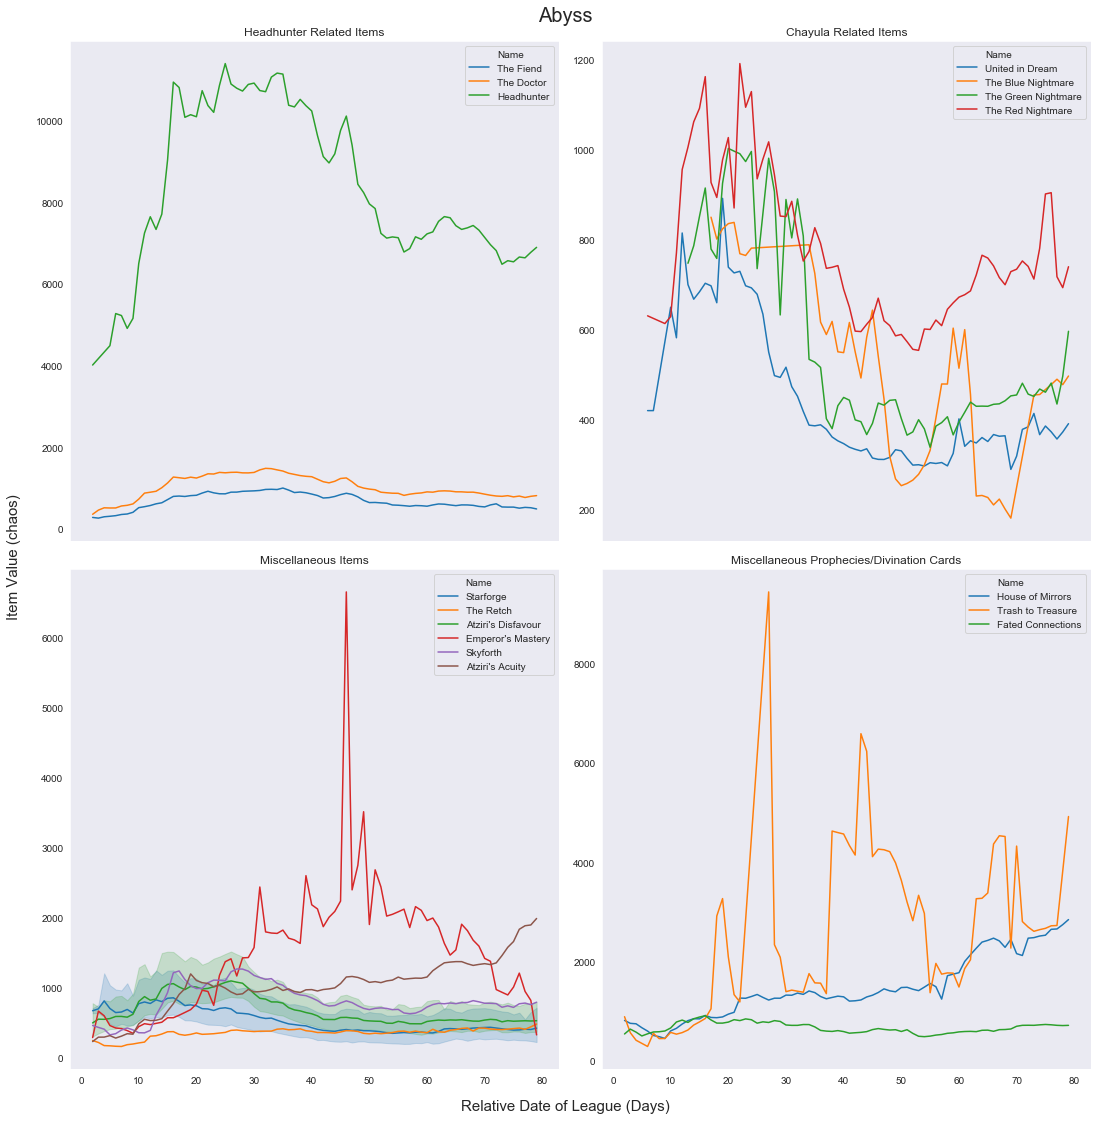

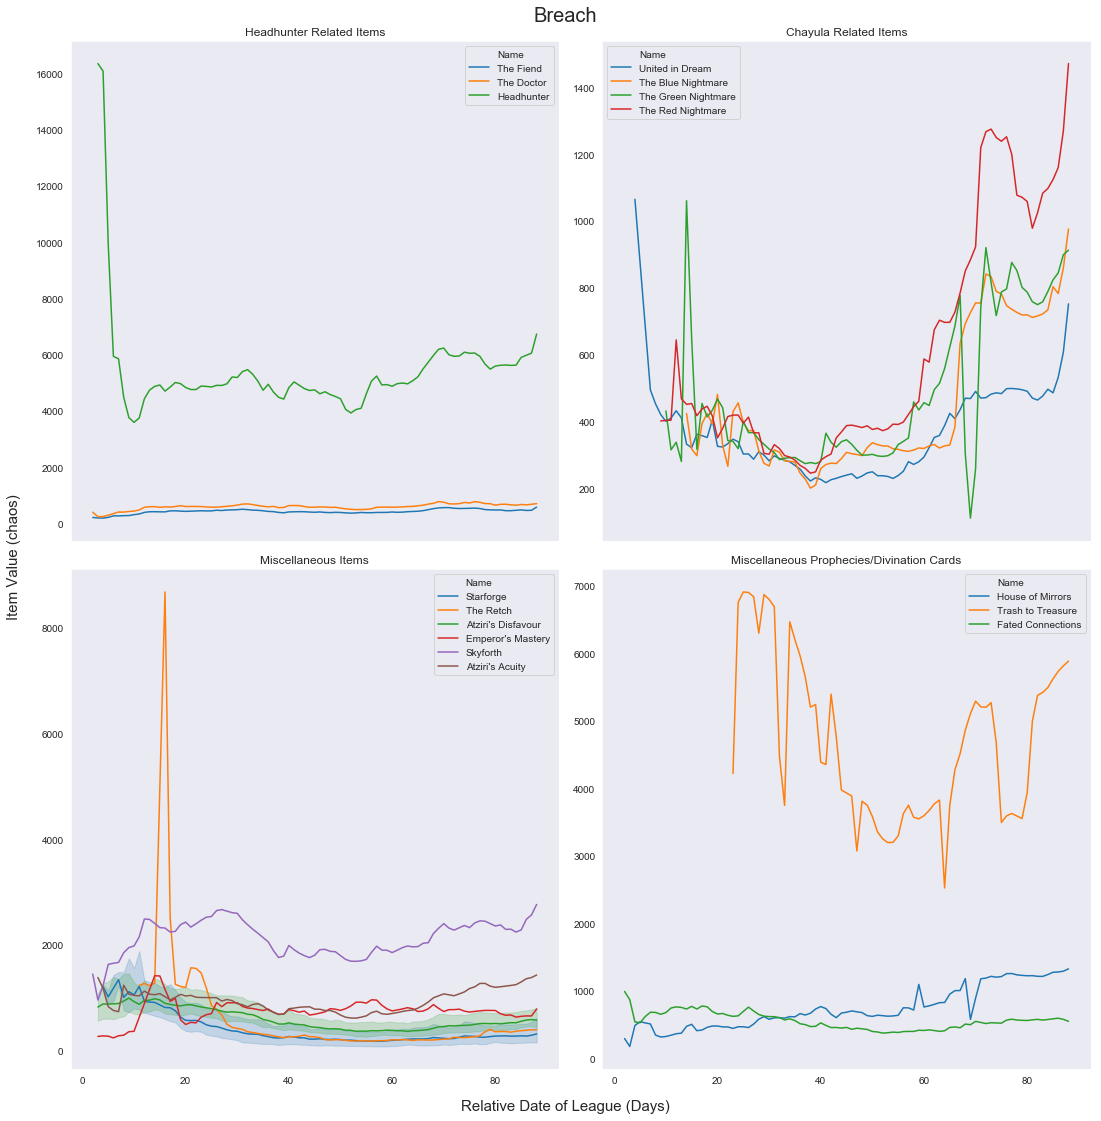

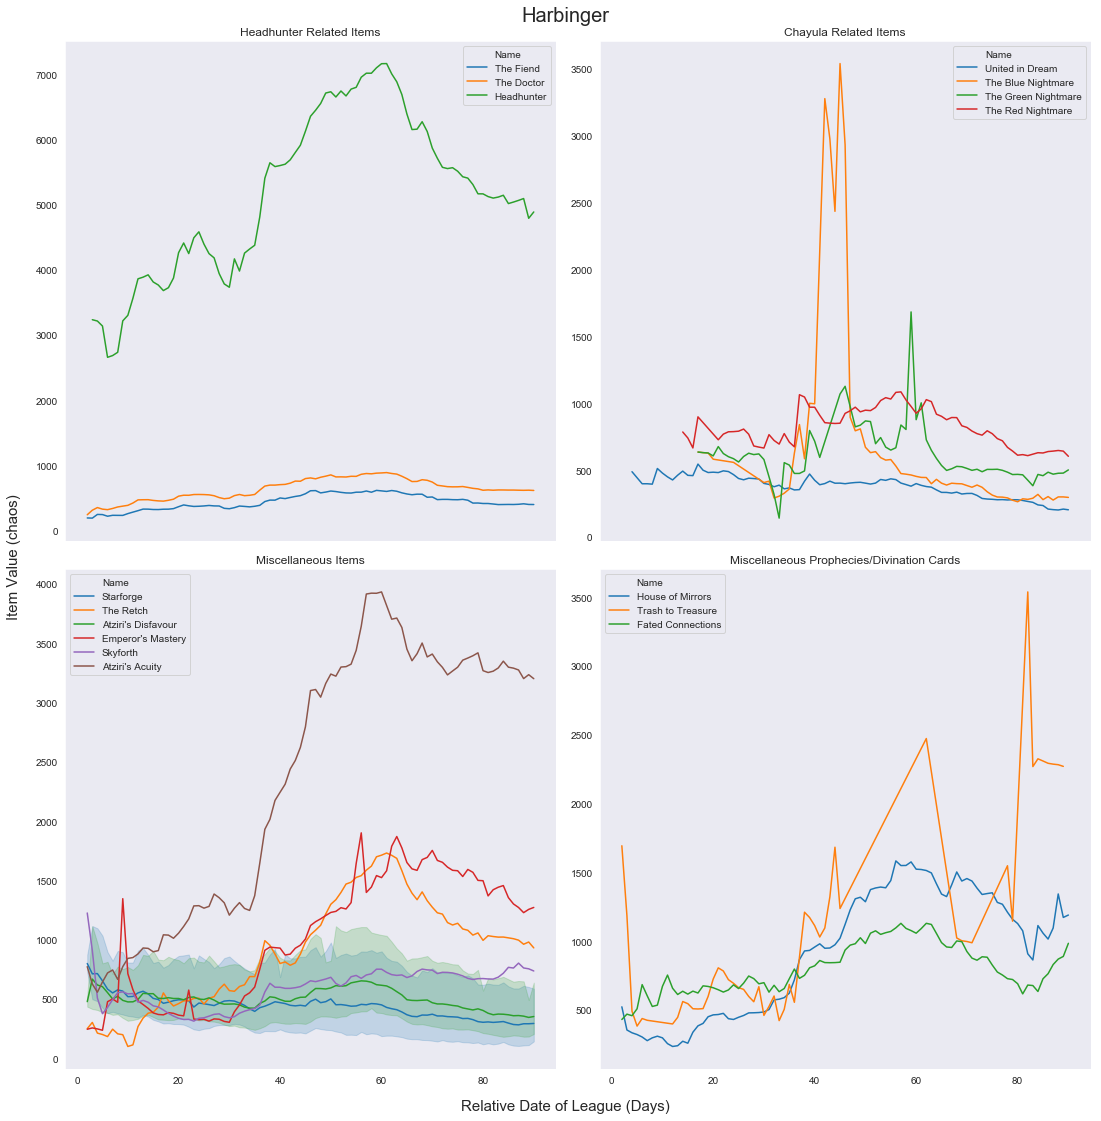

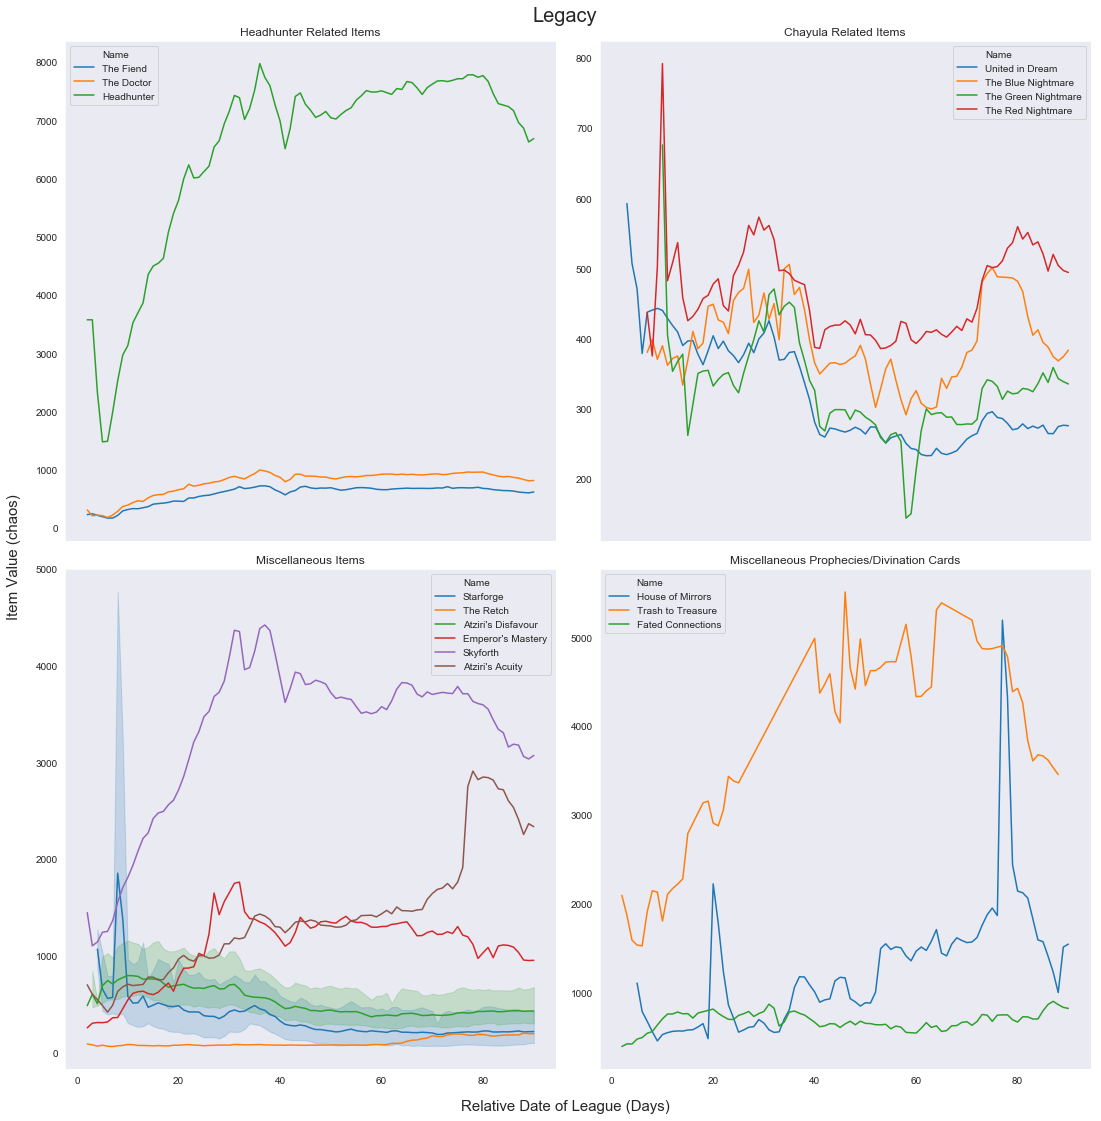

In [337]:
for league in league_name_list:
    league_items = league_indexed_items.loc[league]
    fig, axes = plt.subplots(2, 2, figsize = (15, 15), sharex = True)
    fig.text(0.5, -.01, 'Relative Date of League (Days)', ha='center', va='center', fontsize = 15)
    fig.text(-.01, 0.5, 'Item Value (chaos)', ha='center', va='center', fontsize = 15, rotation = "vertical")
    fig.text(0.5, 1, league, ha='center', va='center', fontsize = 20)
    for ax, i in zip(axes.flat, range(4)):
        df_items = league_items.loc[league_items["Name"].isin(list_of_groups[i])]
        sns.lineplot(x = "RelativeDateInt", y = "Value", hue = "Name", data = df_items, ax = ax, hue_order = list_of_groups[i])
        ax.set(xlabel = "", ylabel = "", title = item_group_names[i])
    fig.tight_layout()

### By Item

In [338]:
item_indexed_items = item_df_pared.set_index("Name")
item_indexed_items = item_indexed_items.sort_index()
item_name_list = list(item_indexed_items.index.unique())
print(item_name_list)
print(len(item_name_list))

["Atziri's Acuity", "Atziri's Disfavour", "Emperor's Mastery", 'Fated Connections', 'Headhunter', 'House of Mirrors', 'Skyforth', 'Starforge', 'The Blue Nightmare', 'The Doctor', 'The Fiend', 'The Green Nightmare', 'The Red Nightmare', 'The Retch', 'Trash to Treasure', 'United in Dream']
16


In [339]:
print(list_of_groups)
print(item_group_names)

[['The Fiend', 'The Doctor', 'Headhunter'], ['United in Dream', 'The Blue Nightmare', 'The Green Nightmare', 'The Red Nightmare'], ['Starforge', 'The Retch', "Atziri's Disfavour", "Emperor's Mastery", 'Skyforth', "Atziri's Acuity"], ['House of Mirrors', 'Trash to Treasure', 'Fated Connections']]
['Headhunter Related Items', 'Chayula Related Items', 'Miscellaneous Items', 'Miscellaneous Prophecies/Divination Cards']


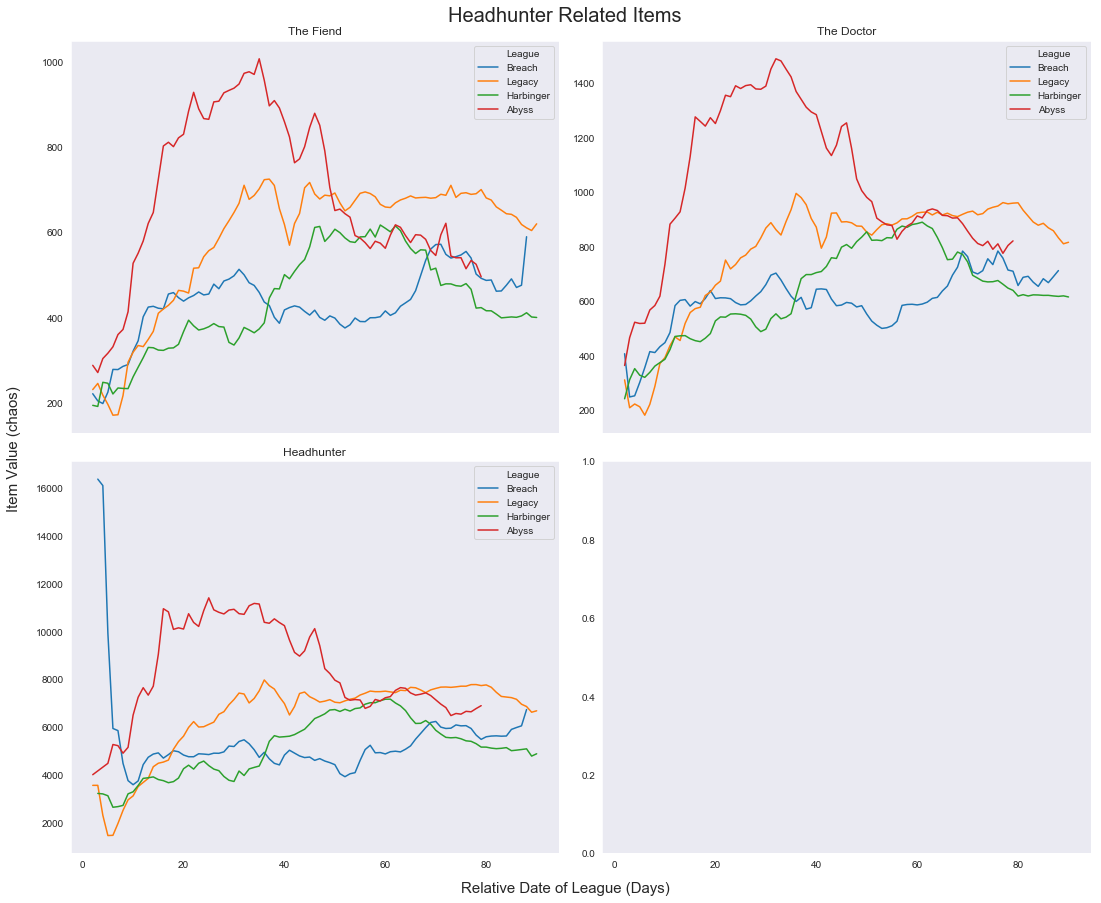

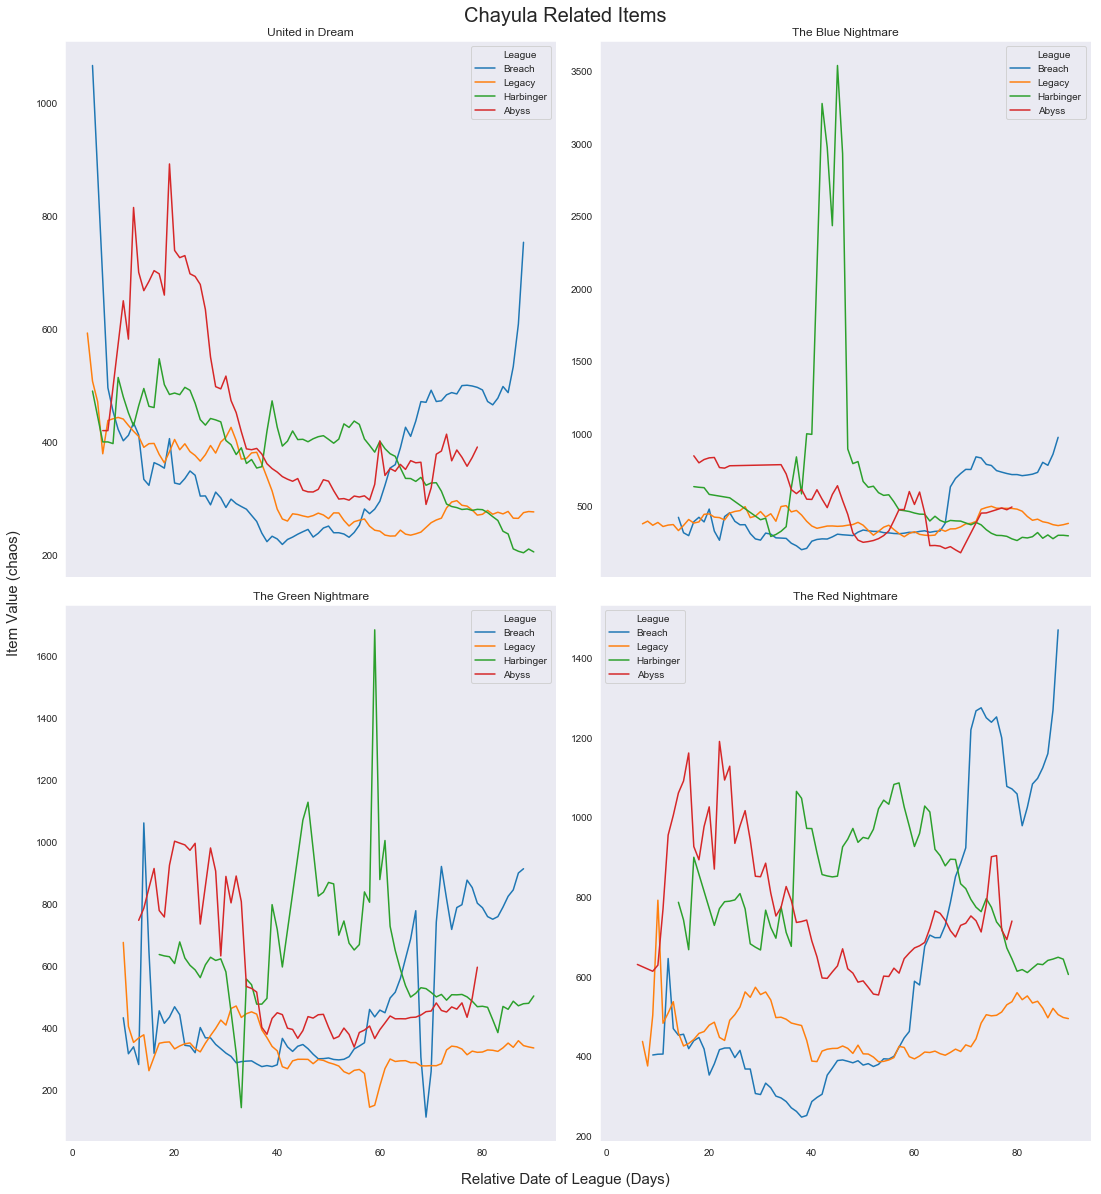

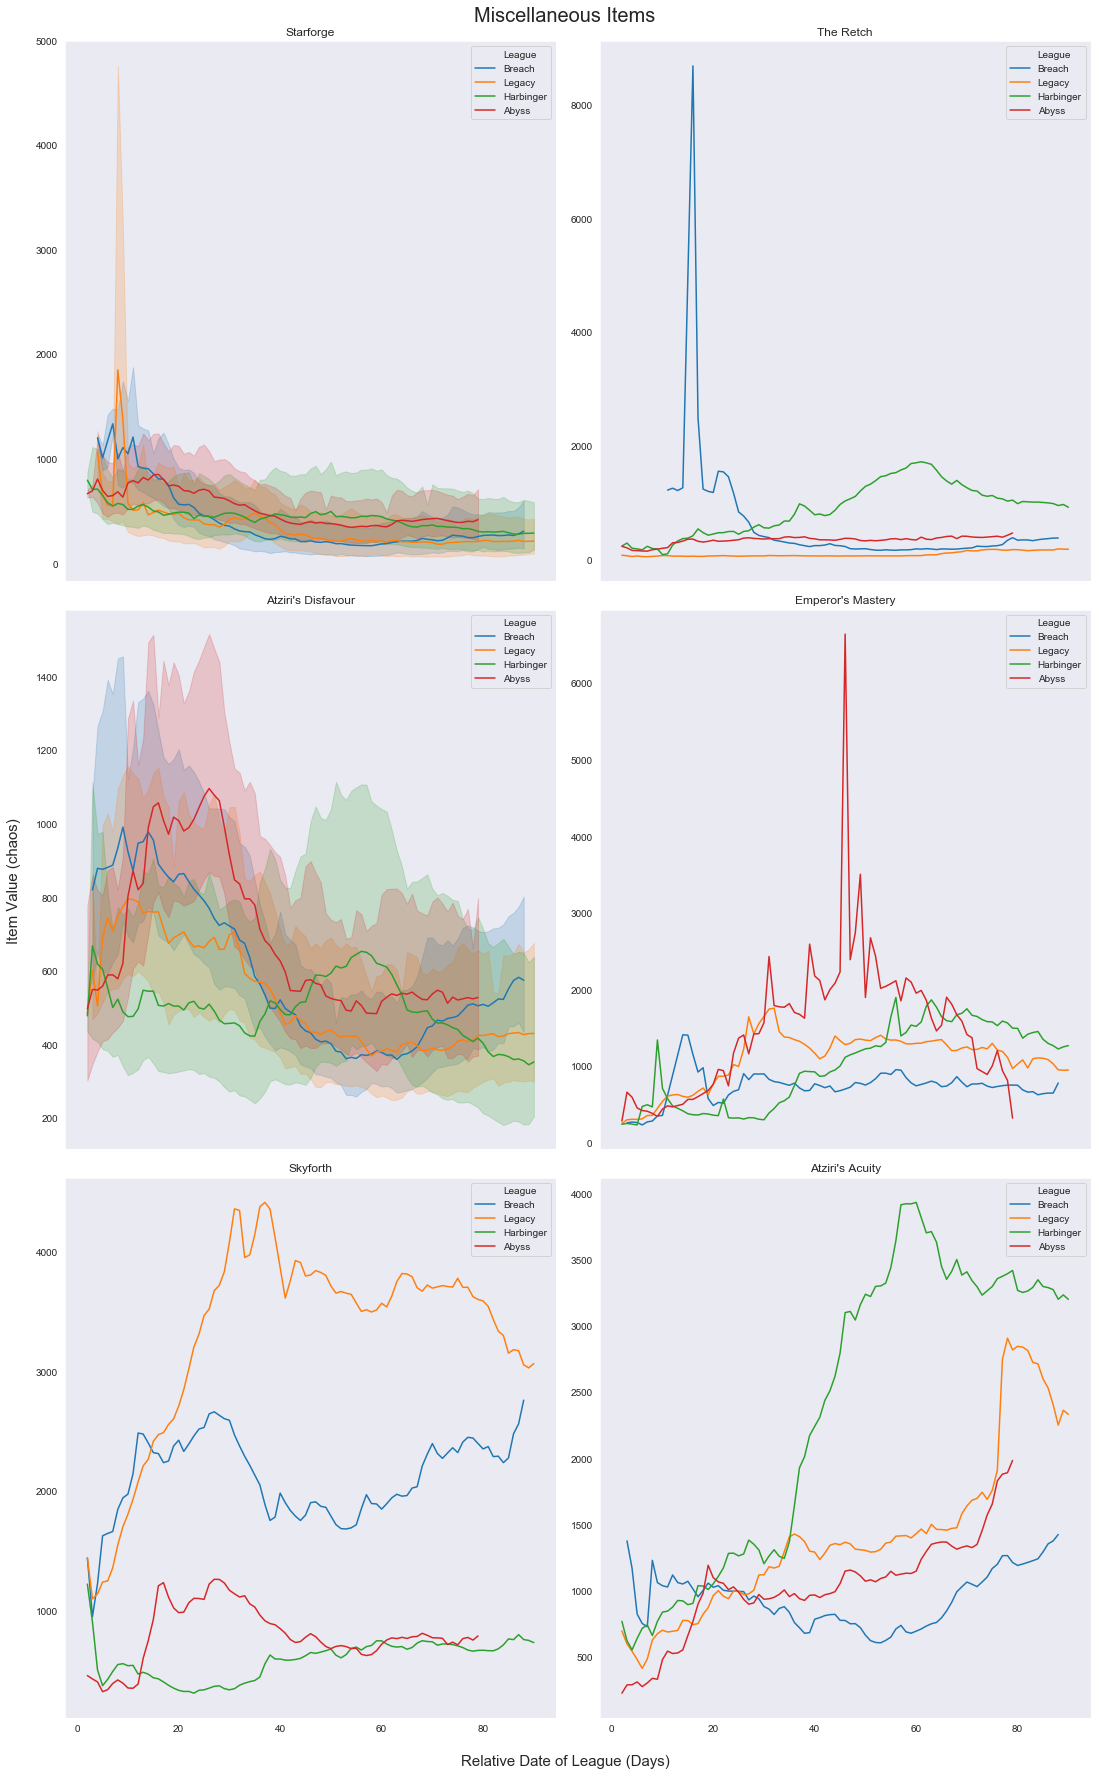

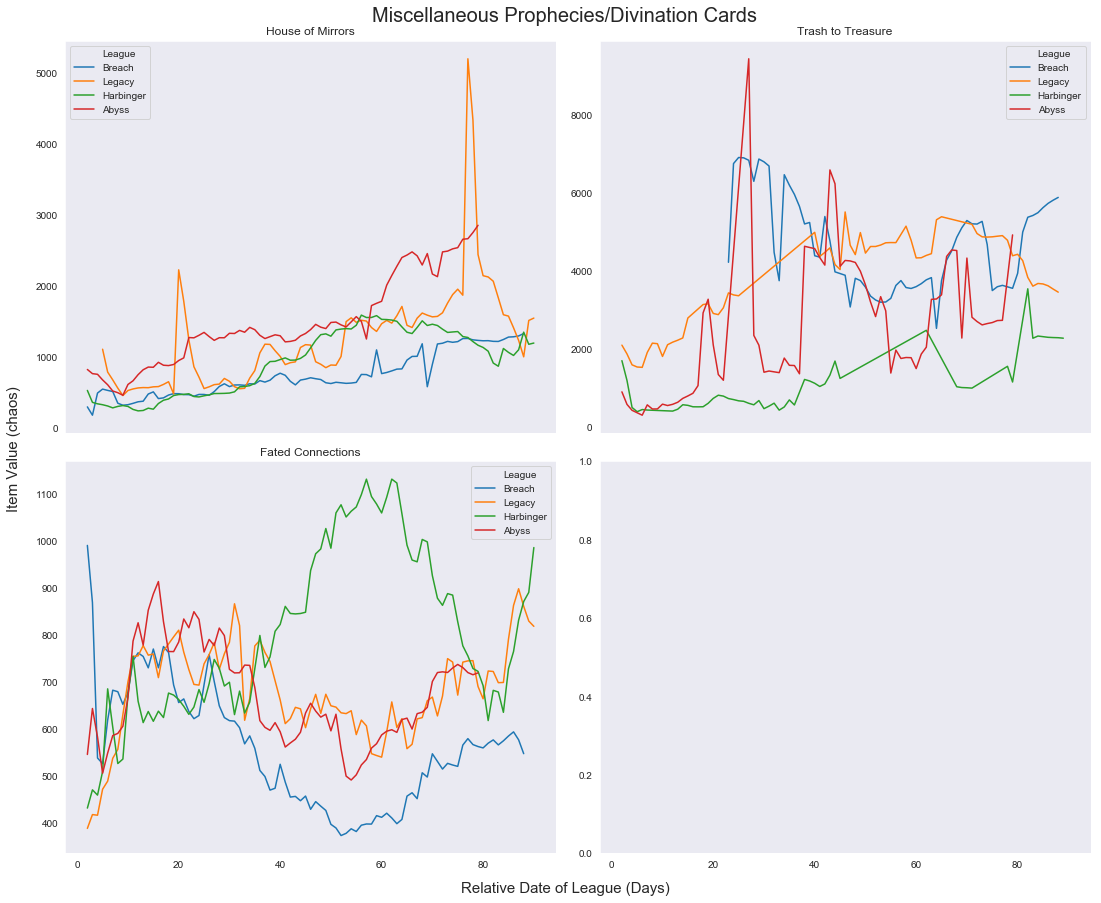

In [340]:
for group, i in zip(list_of_groups, range(len(list_of_groups))):
    fig, axes = plt.subplots(math.ceil(len(group)/2), 2, figsize = (15, len(group)*4), sharex = True)
    fig.text(0.5, -.01, 'Relative Date of League (Days)', ha='center', va='center', fontsize = 15)
    fig.text(-.01, 0.5, 'Item Value (chaos)', ha='center', va='center', fontsize = 15, rotation = "vertical")
    fig.text(0.5, 1, item_group_names[i], ha='center', va='center', fontsize = 20)
    for ax, item in zip(axes.flat, group):
        item_values = item_indexed_items.loc[item]
        sns.lineplot(x = "RelativeDateInt", y = "Value", hue = "League", data = item_values, hue_order = ["Breach", "Legacy", "Harbinger", "Abyss"], ax = ax)
        ax.set(xlabel = "", ylabel = "", title = item)
    fig.tight_layout()

## Currency Trends
### More Data Cleaning

In [341]:
currency_df_edited.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30475 entries, 358 to 9466
Data columns (total 8 columns):
League             30475 non-null object
Get                30475 non-null object
Pay                30475 non-null object
Value              30475 non-null float64
Confidence         30475 non-null object
RelativeDate       30475 non-null timedelta64[ns]
RelativeDateInt    30475 non-null float64
League Lifespan    30475 non-null object
dtypes: float64(2), object(5), timedelta64[ns](1)
memory usage: 2.1+ MB


In [342]:
def common_currency(df):
    unique_currencies = []
    for league in df.League.unique():
        league_df = df[df.League == league]
        unique_currencies.append(league_df.Get.unique().tolist())
        unique_currencies.append(league_df.Pay.unique().tolist())
    return list(set(unique_currencies[0]).intersection(*unique_currencies))

In [343]:
list_of_currencies = common_currency(currency_df_edited)
print(np.sort(list_of_currencies))
print(len(list_of_currencies))

["Apprentice Cartographer's Sextant" 'Blessed Orb' 'Blessing of Chayula'
 'Blessing of Esh' 'Blessing of Tul' 'Blessing of Uul-Netol'
 'Blessing of Xoph' "Cartographer's Chisel" 'Chaos Orb'
 "Chayula's Breachstone" 'Divine Orb' "Eber's Key" "Esh's Breachstone"
 'Exalted Orb' 'Fragment of the Chimera' 'Fragment of the Hydra'
 'Fragment of the Minotaur' 'Fragment of the Phoenix' "Gemcutter's Prism"
 "Inya's Key" "Jeweller's Orb" "Journeyman Cartographer's Sextant"
 "Master Cartographer's Sextant" 'Mortal Grief' 'Mortal Hope'
 'Mortal Ignorance' 'Mortal Rage' 'Offering to the Goddess'
 'Orb of Alchemy' 'Orb of Fusing' 'Orb of Regret' 'Orb of Scouring'
 'Regal Orb' 'Sacrifice at Dawn' 'Sacrifice at Dusk'
 'Sacrifice at Midnight' 'Sacrifice at Noon' 'Splinter of Chayula'
 "Tul's Breachstone" "Uul-Netol's Breachstone" 'Vaal Orb' "Volkuur's Key"
 "Xoph's Breachstone" "Yriel's Key"]
44


In [344]:
currency_to_pay = ["Apprentice Cartographer's Sextant", "Blessed Orb", "Cartographer's Chisel", "Chaos Orb", "Exalted Orb", "Journeyman Cartographer's Sextant", "Master Cartographer's Sextant", "Orb of Alchemy", "Orb of Fusing", "Regal Orb"]
currency_df_pared = currency_df_pared.loc[currency_df_edited["Get"].isin(list_of_currencies) & currency_df_pared["Pay"].isin(currency_to_pay)]
currency_df_pared.info()
currency_df_pared.Pay.unique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17838 entries, 358 to 8760
Data columns (total 8 columns):
League             17838 non-null object
Get                17838 non-null object
Pay                17838 non-null object
Value              17838 non-null float64
Confidence         17838 non-null object
RelativeDate       17838 non-null timedelta64[ns]
RelativeDateInt    17838 non-null float64
League Lifespan    17838 non-null object
dtypes: float64(2), object(5), timedelta64[ns](1)
memory usage: 1.2+ MB


array(['Chaos Orb', 'Orb of Fusing', 'Orb of Alchemy', 'Exalted Orb',
       'Regal Orb', "Cartographer's Chisel", 'Blessed Orb',
       "Journeyman Cartographer's Sextant",
       "Master Cartographer's Sextant",
       "Apprentice Cartographer's Sextant"], dtype=object)

In [366]:
# Setting up different filter groups for the currencies based off of relatedness

exalts_divines = ["Exalted Orb", "Divine Orb"]
major_orbs = ["Orb of Regret", "Gemcutter's Prism", "Regal Orb", "Vaal Orb"]
minor_orbs = ["Blessed Orb", "Cartographer's Chisel", "Orb of Scouring", "Jeweller's Orb", "Orb of Alchemy", "Orb of Fusing"]
mapping_items = ["Apprentice Cartographer's Sextant", "Journeyman Cartographer's Sextant", "Master Cartographer's Sextant"]
atziri = ['Sacrifice at Dawn', 'Sacrifice at Dusk', 'Sacrifice at Midnight', 'Sacrifice at Noon']
uber_atziri = ['Mortal Grief', 'Mortal Hope', 'Mortal Ignorance', 'Mortal Rage']
shaper_frags = ['Fragment of the Chimera', 'Fragment of the Hydra', 'Fragment of the Minotaur', 'Fragment of the Phoenix']
breach_blessings = ['Blessing of Chayula', 'Blessing of Esh', 'Blessing of Tul', 'Blessing of Uul-Netol', 'Blessing of Xoph']
breach_items = ["Chayula's Breachstone", "Esh's Breachstone", "Tul's Breachstone", "Uul-Netol's Breachstone", "Splinter of Chayula"]
council_keys = ["Eber's Key", "Inya's Key", "Volkuur's Key", "Yriel's Key"]
offering = ["Offering to the Goddess"]

In [346]:
non_orb_groups = [sextants, atziri, uber_atziri, shaper_frags, breach_blessings, breach_items, council_keys, offering]
non_orb_groups_names = ["Sextants", "Atziri Fragments", "Uber Atziri Fragments", "Shaper Fragments", "Breach Blessings", "Breachstone Items", "Council Keys", "Offering to the Goddess"]

### By League

In [347]:
league_indexed_currency = currency_df_pared.set_index("League")
league_indexed_currency = league_indexed_currency.sort_index()
league_indexed_currency.head()

Get        Pay     Value Confidence RelativeDate  \
League                                                                         
Abyss   Uul-Netol's Breachstone  Chaos Orb  11.08956       High      80 days   
Abyss               Blessed Orb  Chaos Orb   0.33142       High      32 days   
Abyss               Blessed Orb  Chaos Orb   0.33313       High      31 days   
Abyss               Blessed Orb  Chaos Orb   0.33333       High      30 days   
Abyss               Blessed Orb  Chaos Orb   0.33333       High      29 days   

        RelativeDateInt League Lifespan  
League                                   
Abyss              80.0             End  
Abyss              32.0             Mid  
Abyss              31.0             Mid  
Abyss              30.0             Mid  
Abyss              29.0             Mid

In [348]:
abyss_currency = league_indexed_currency.loc["Abyss"]
abyss_currency.head()

Get        Pay     Value Confidence RelativeDate  \
League                                                                         
Abyss   Uul-Netol's Breachstone  Chaos Orb  11.08956       High      80 days   
Abyss               Blessed Orb  Chaos Orb   0.33142       High      32 days   
Abyss               Blessed Orb  Chaos Orb   0.33313       High      31 days   
Abyss               Blessed Orb  Chaos Orb   0.33333       High      30 days   
Abyss               Blessed Orb  Chaos Orb   0.33333       High      29 days   

        RelativeDateInt League Lifespan  
League                                   
Abyss              80.0             End  
Abyss              32.0             Mid  
Abyss              31.0             Mid  
Abyss              30.0             Mid  
Abyss              29.0             Mid

#### Comparing non-orb values to chaos values

In [349]:
abyss_chaos = abyss_currency[abyss_currency.Pay == "Chaos Orb"]
abyss_chaos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3391 entries, Abyss to Abyss
Data columns (total 7 columns):
Get                3391 non-null object
Pay                3391 non-null object
Value              3391 non-null float64
Confidence         3391 non-null object
RelativeDate       3391 non-null timedelta64[ns]
RelativeDateInt    3391 non-null float64
League Lifespan    3391 non-null object
dtypes: float64(2), object(4), timedelta64[ns](1)
memory usage: 211.9+ KB


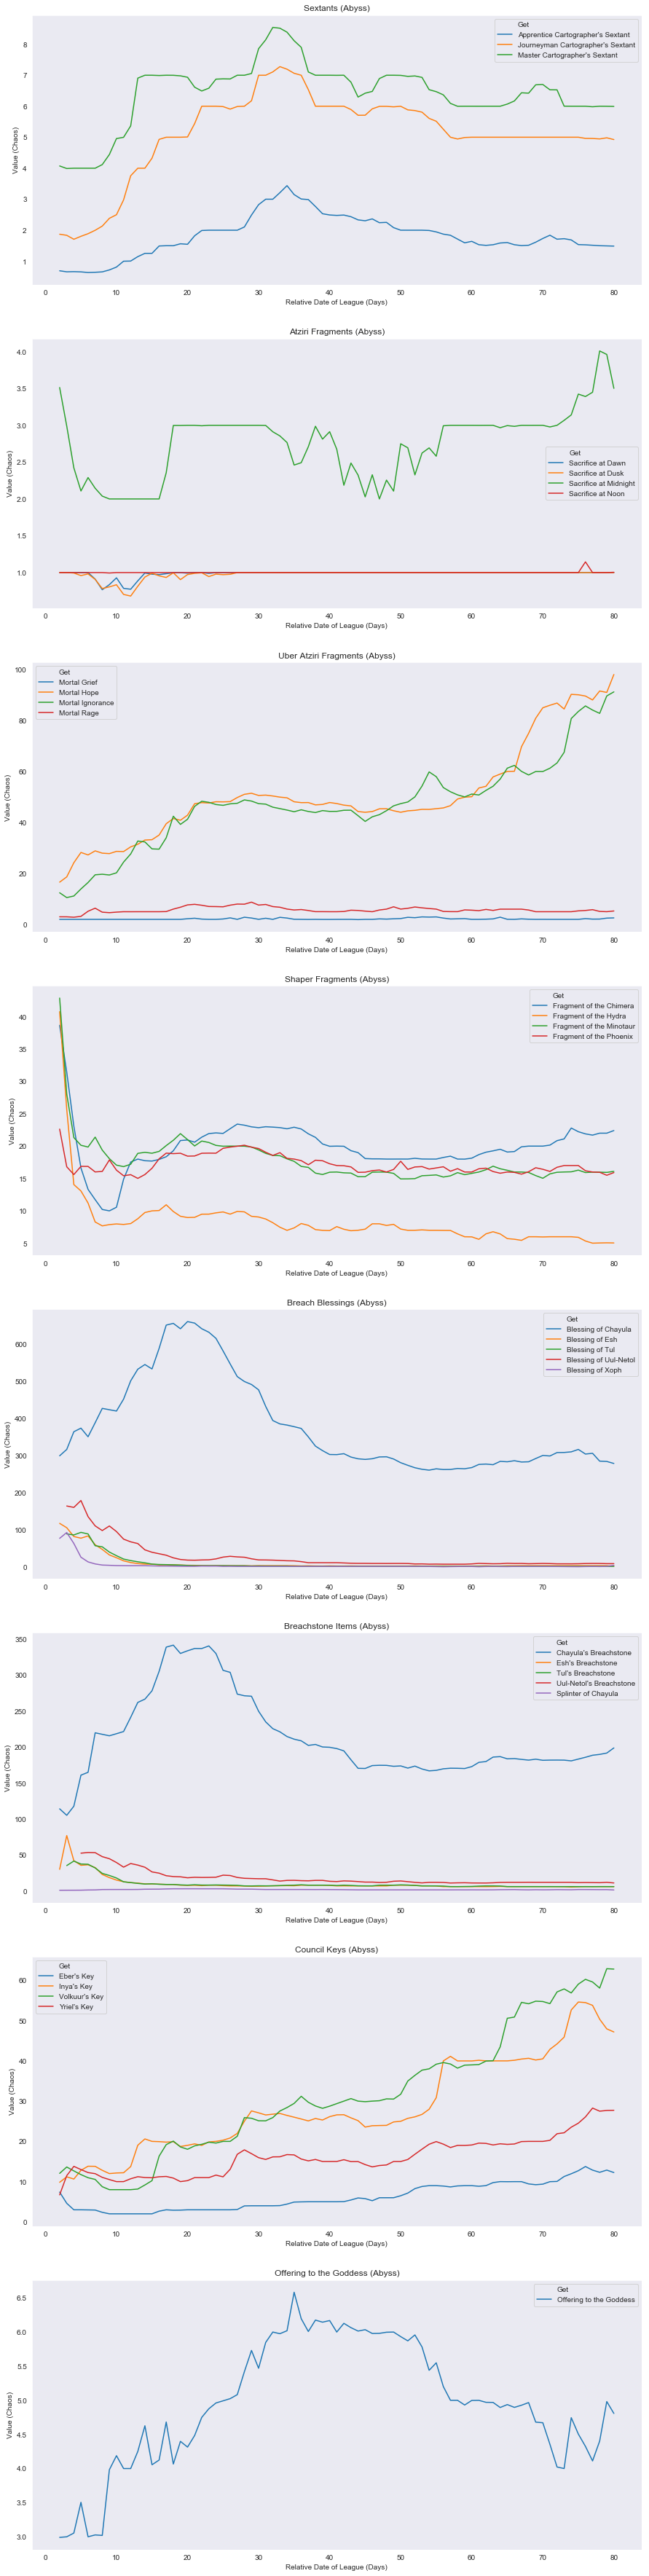

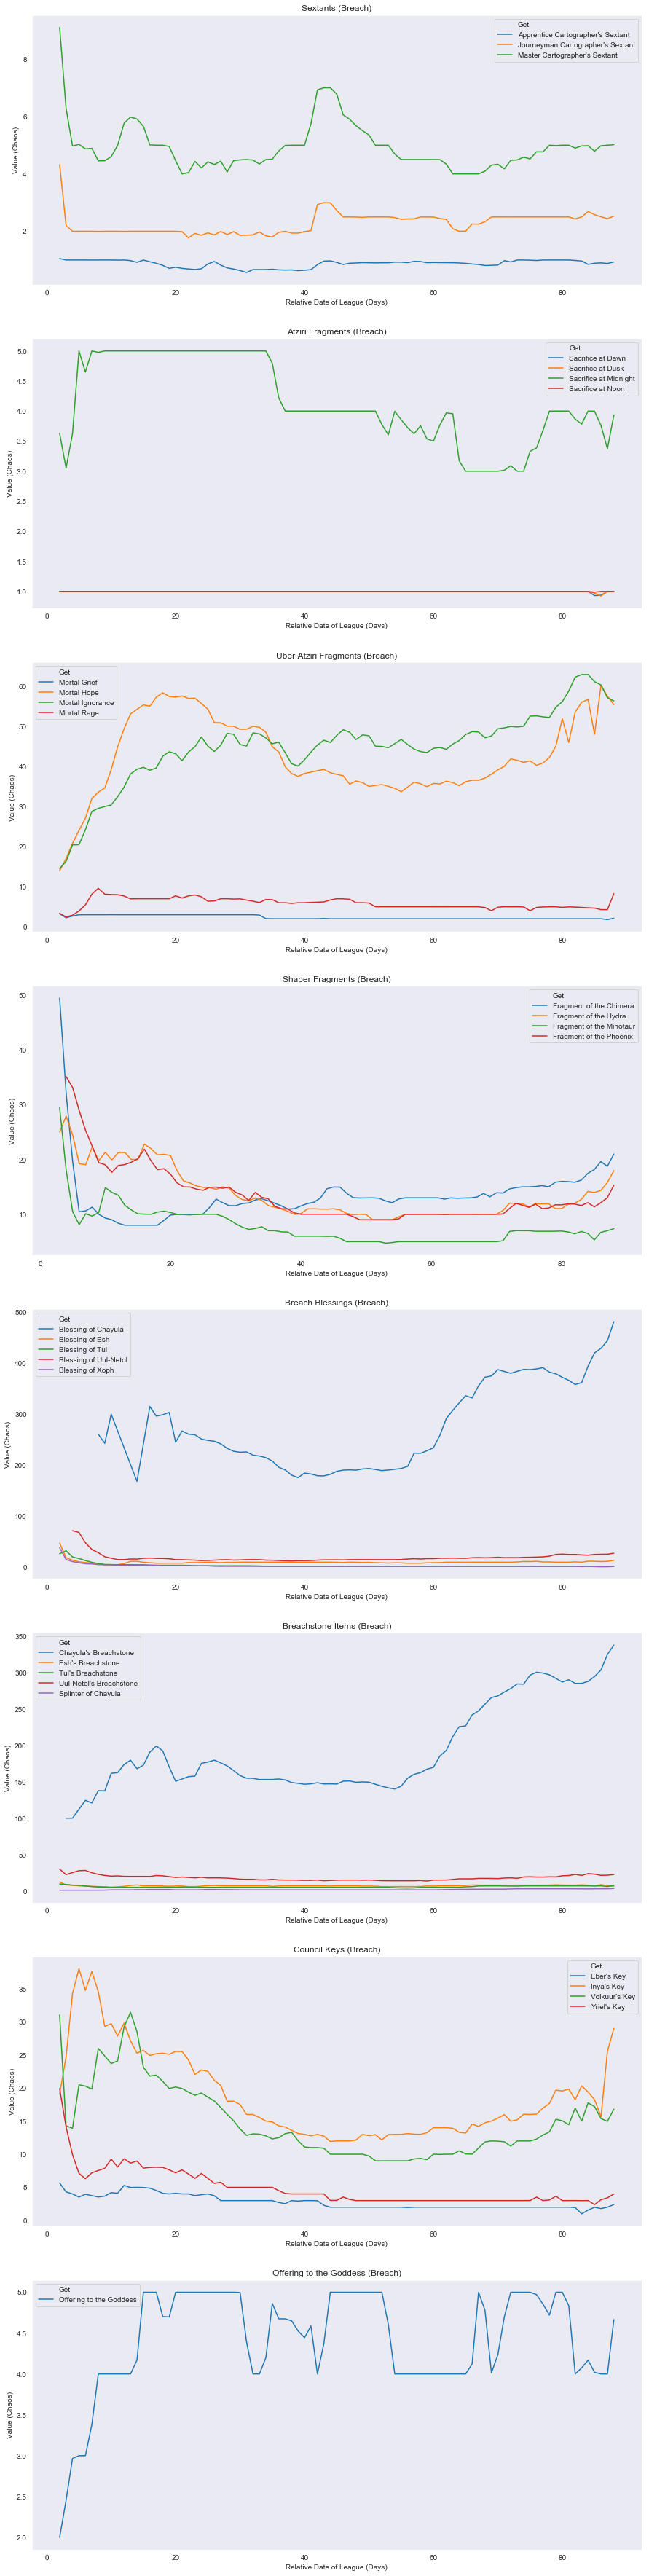

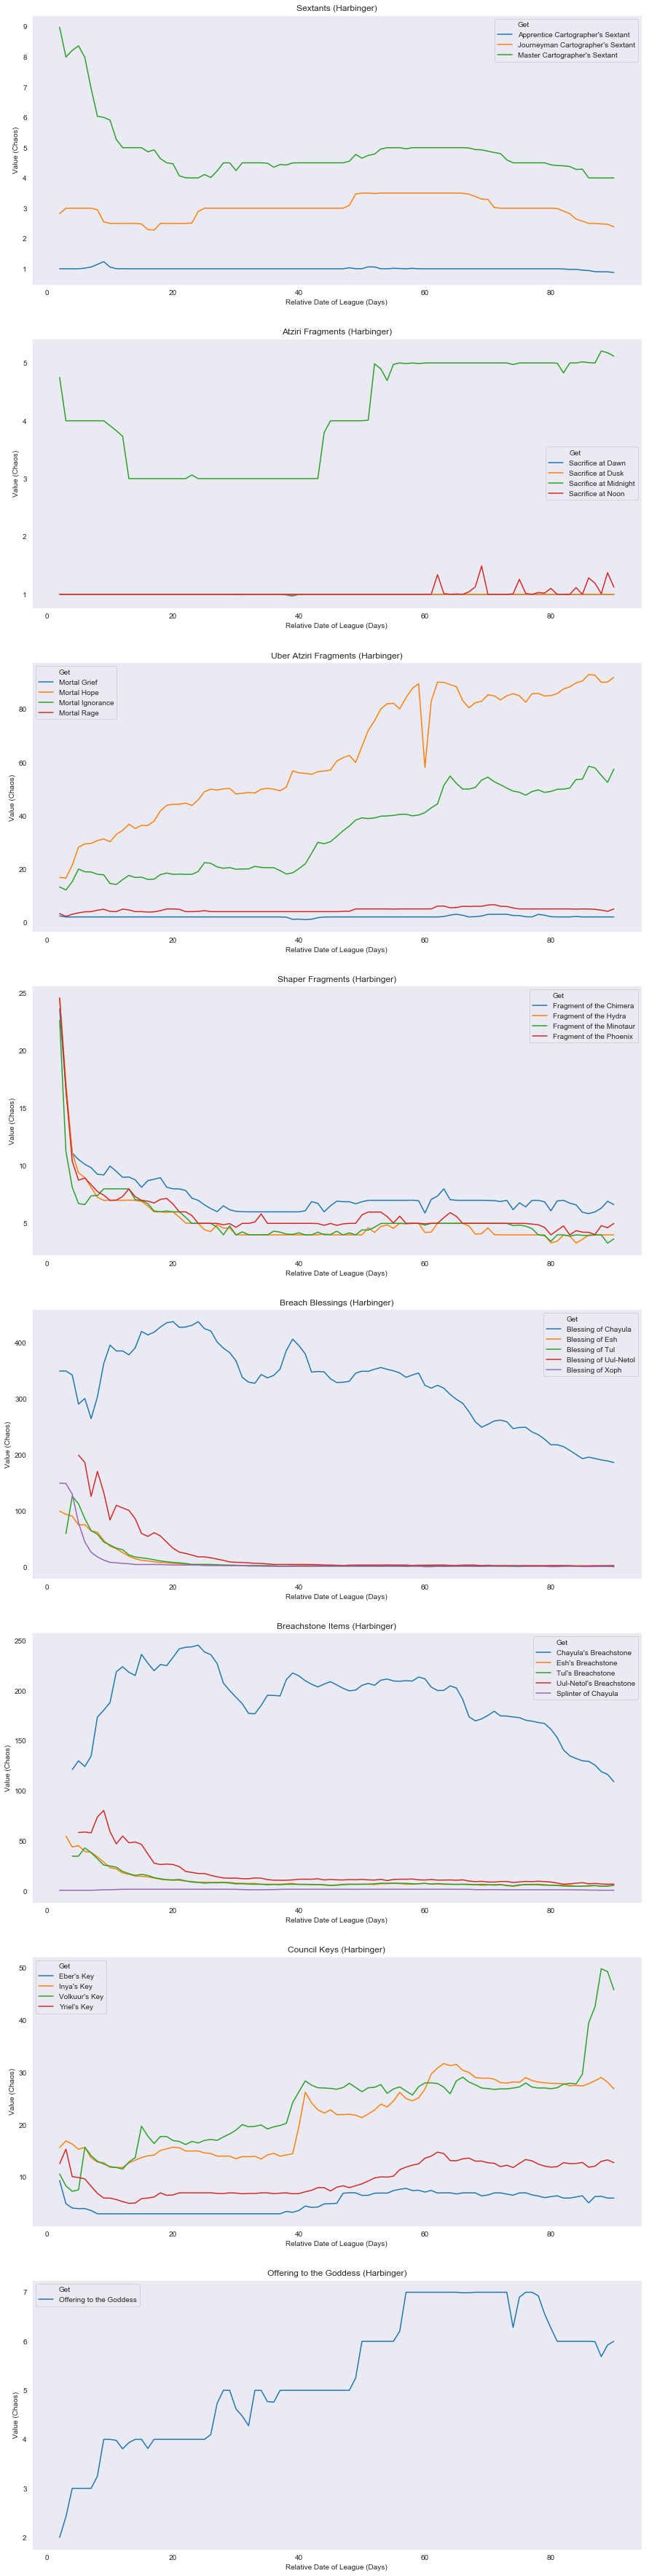

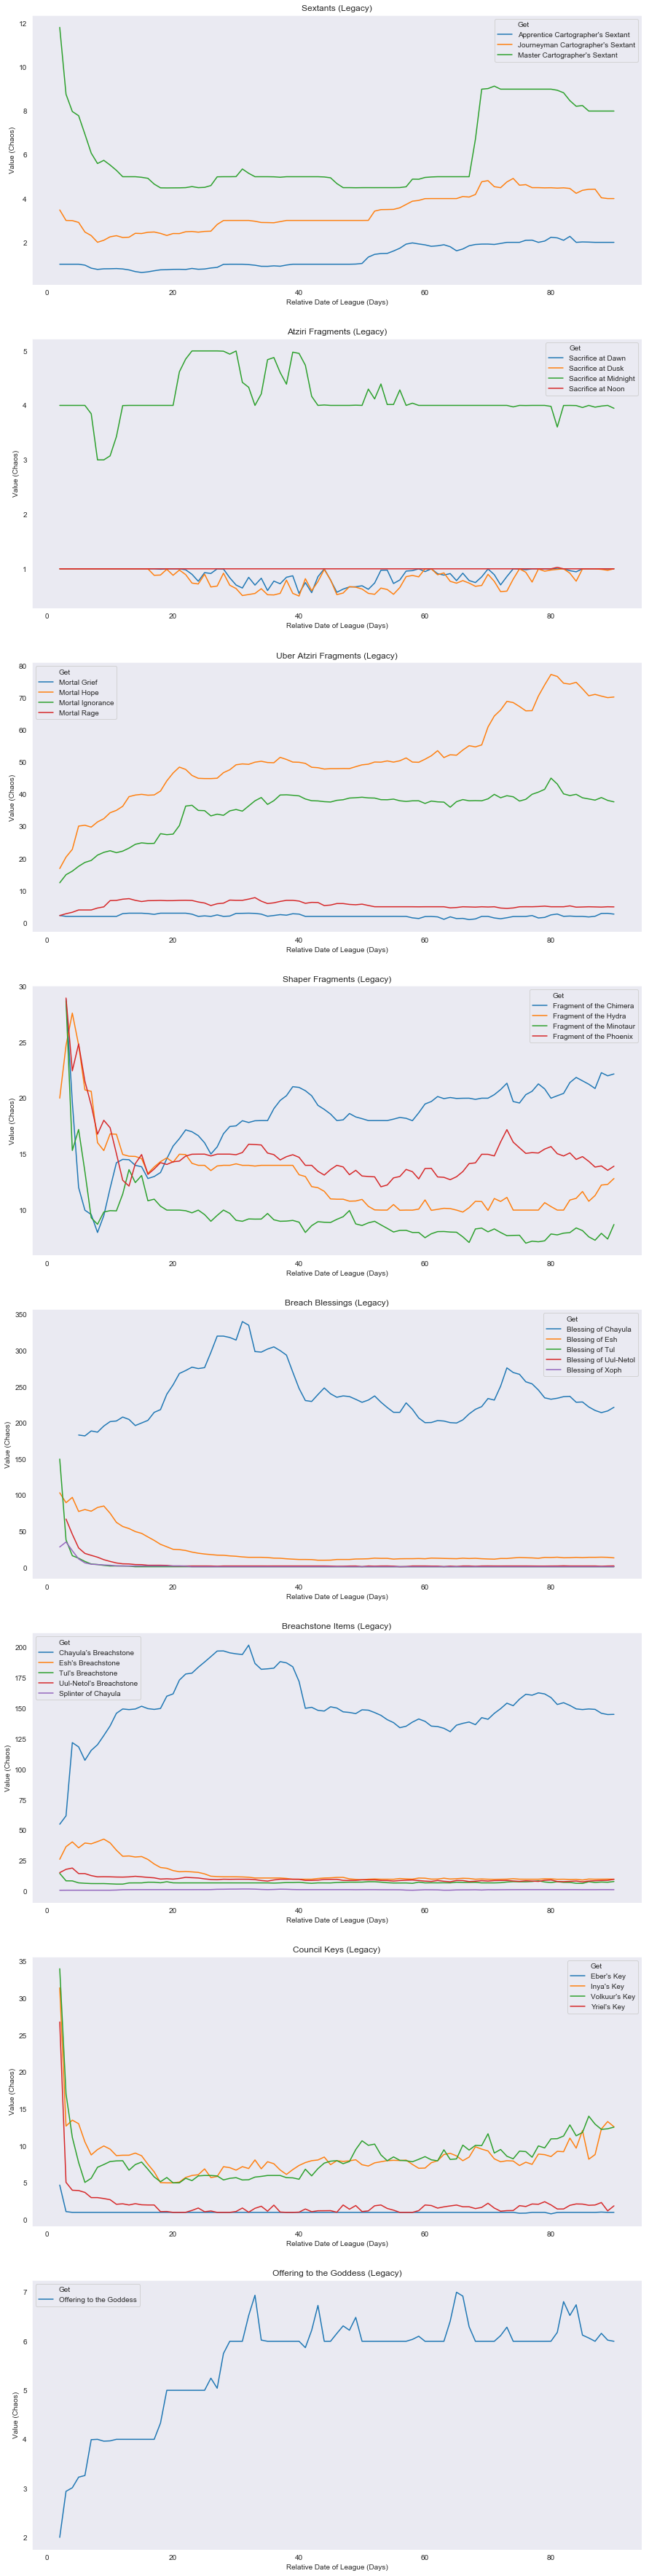

In [350]:
for league in league_name_list:
    league_currency = league_indexed_currency.loc[league]
    league_chaos = league_currency[league_currency.Pay == "Chaos Orb"]
    fig, axes = plt.subplots(len(non_orb_groups), 1, figsize = (15, len(non_orb_groups)*8))
    for ax, group, group_name in zip(axes.flat, non_orb_groups, non_orb_groups_names):
        df_currency = league_chaos.loc[league_chaos["Get"].isin(group)]
        sns.lineplot(x = "RelativeDateInt", y = "Value", hue = "Get", data = df_currency, ax = ax, hue_order = group)
        ax.set(xlabel = "Relative Date of League (Days)", ylabel = "Value (Chaos)", title = group_name + " (" + league + ")")

#### Comparing orb values to chaos values

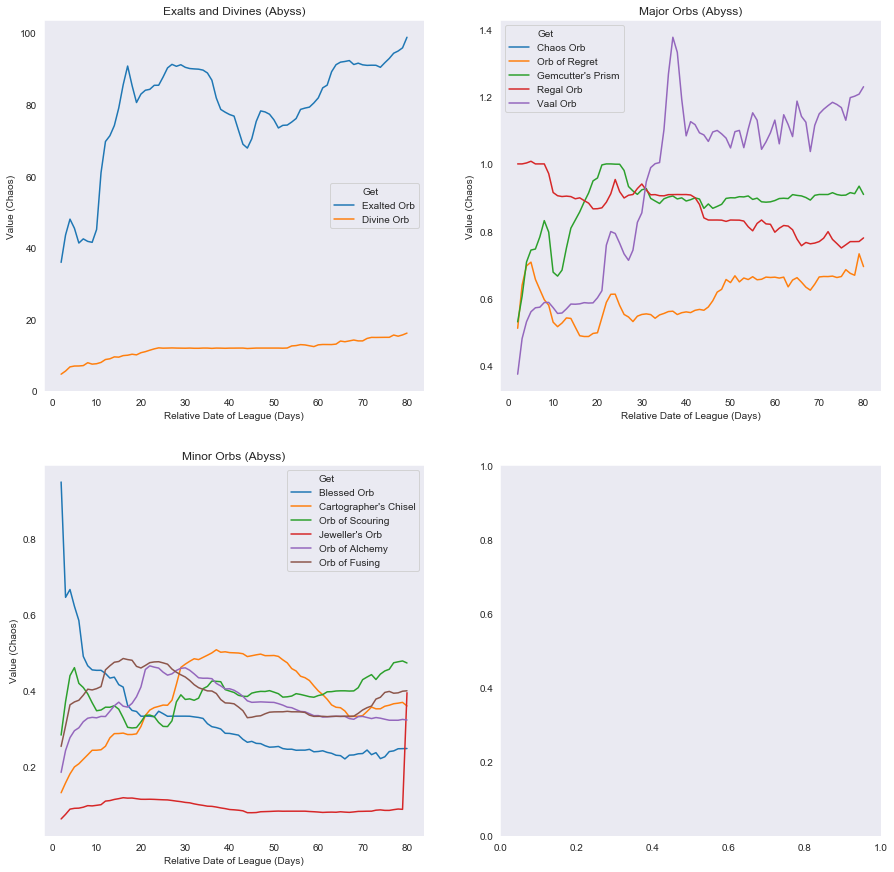

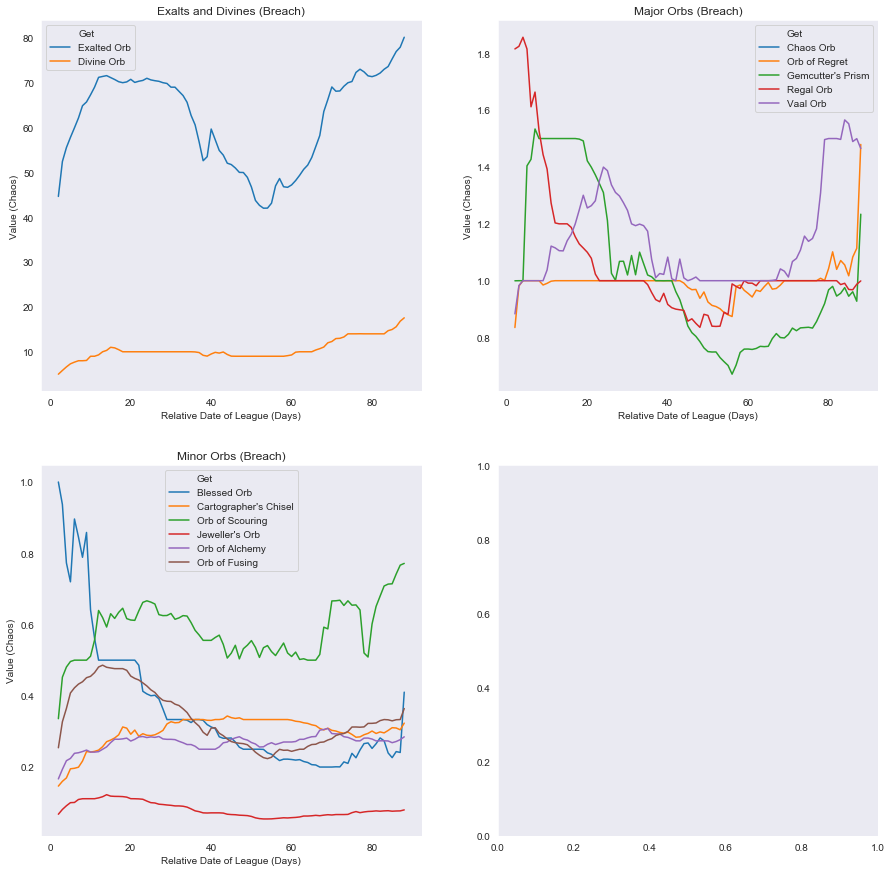

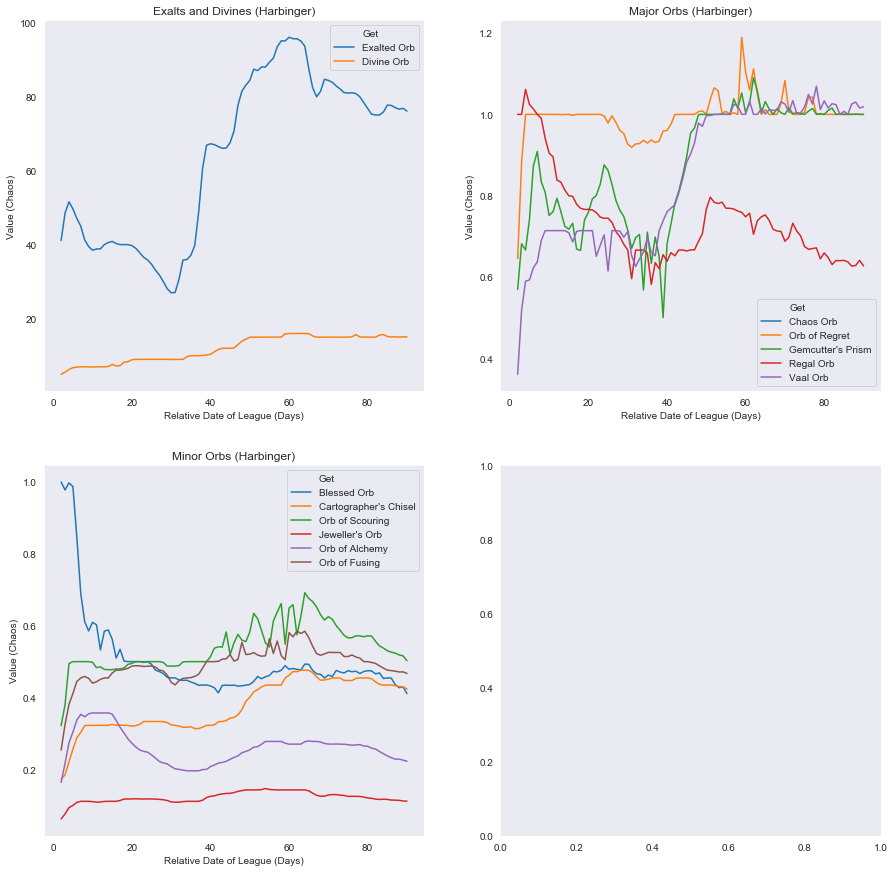

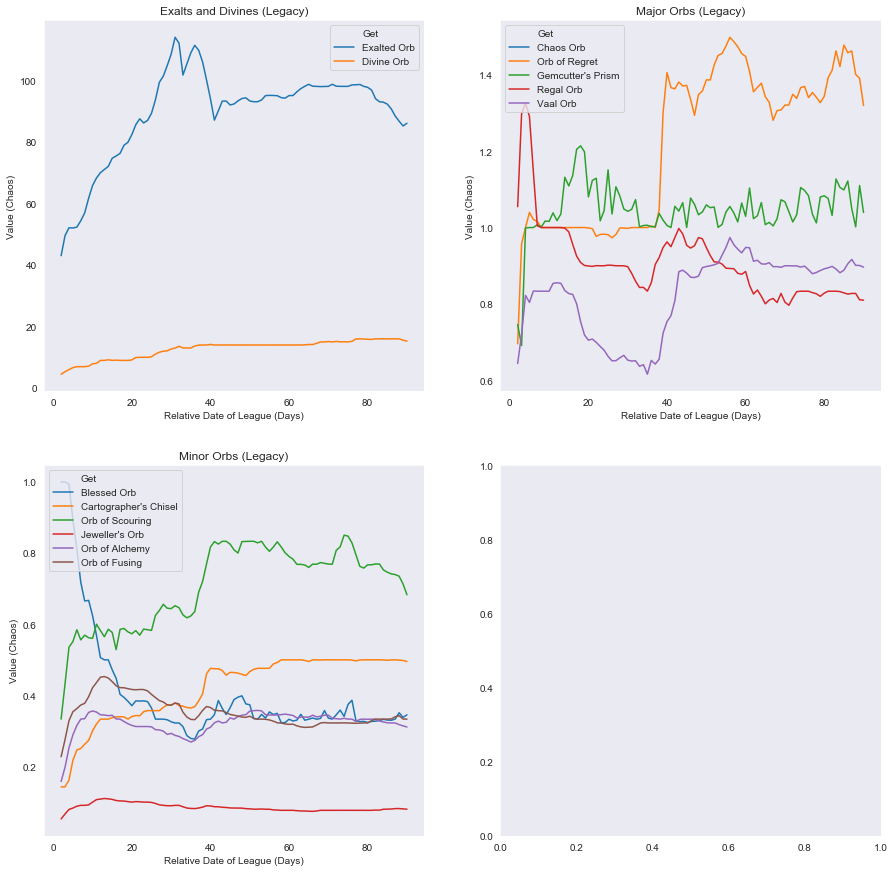

In [351]:
for league in league_name_list:
    league_currency = league_indexed_currency.loc[league]
    league_chaos = league_currency[league_currency.Pay == "Chaos Orb"]
    fig, axes = plt.subplots(2, 2, figsize = (15, 15))
    for ax, group, group_name in zip(axes.flat, , ["Exalts and Divines", "Major Orbs", "Minor Orbs"]):
        df_currency = league_chaos.loc[league_chaos["Get"].isin(group)]
        sns.lineplot(x = "RelativeDateInt", y = "Value", hue = "Get", data = df_currency, ax = ax, hue_order = group)
        ax.set(xlabel = "Relative Date of League (Days)", ylabel = "Value (Chaos)", title = group_name + " (" + league + ")")

#### Boxplots for Major Orbs:

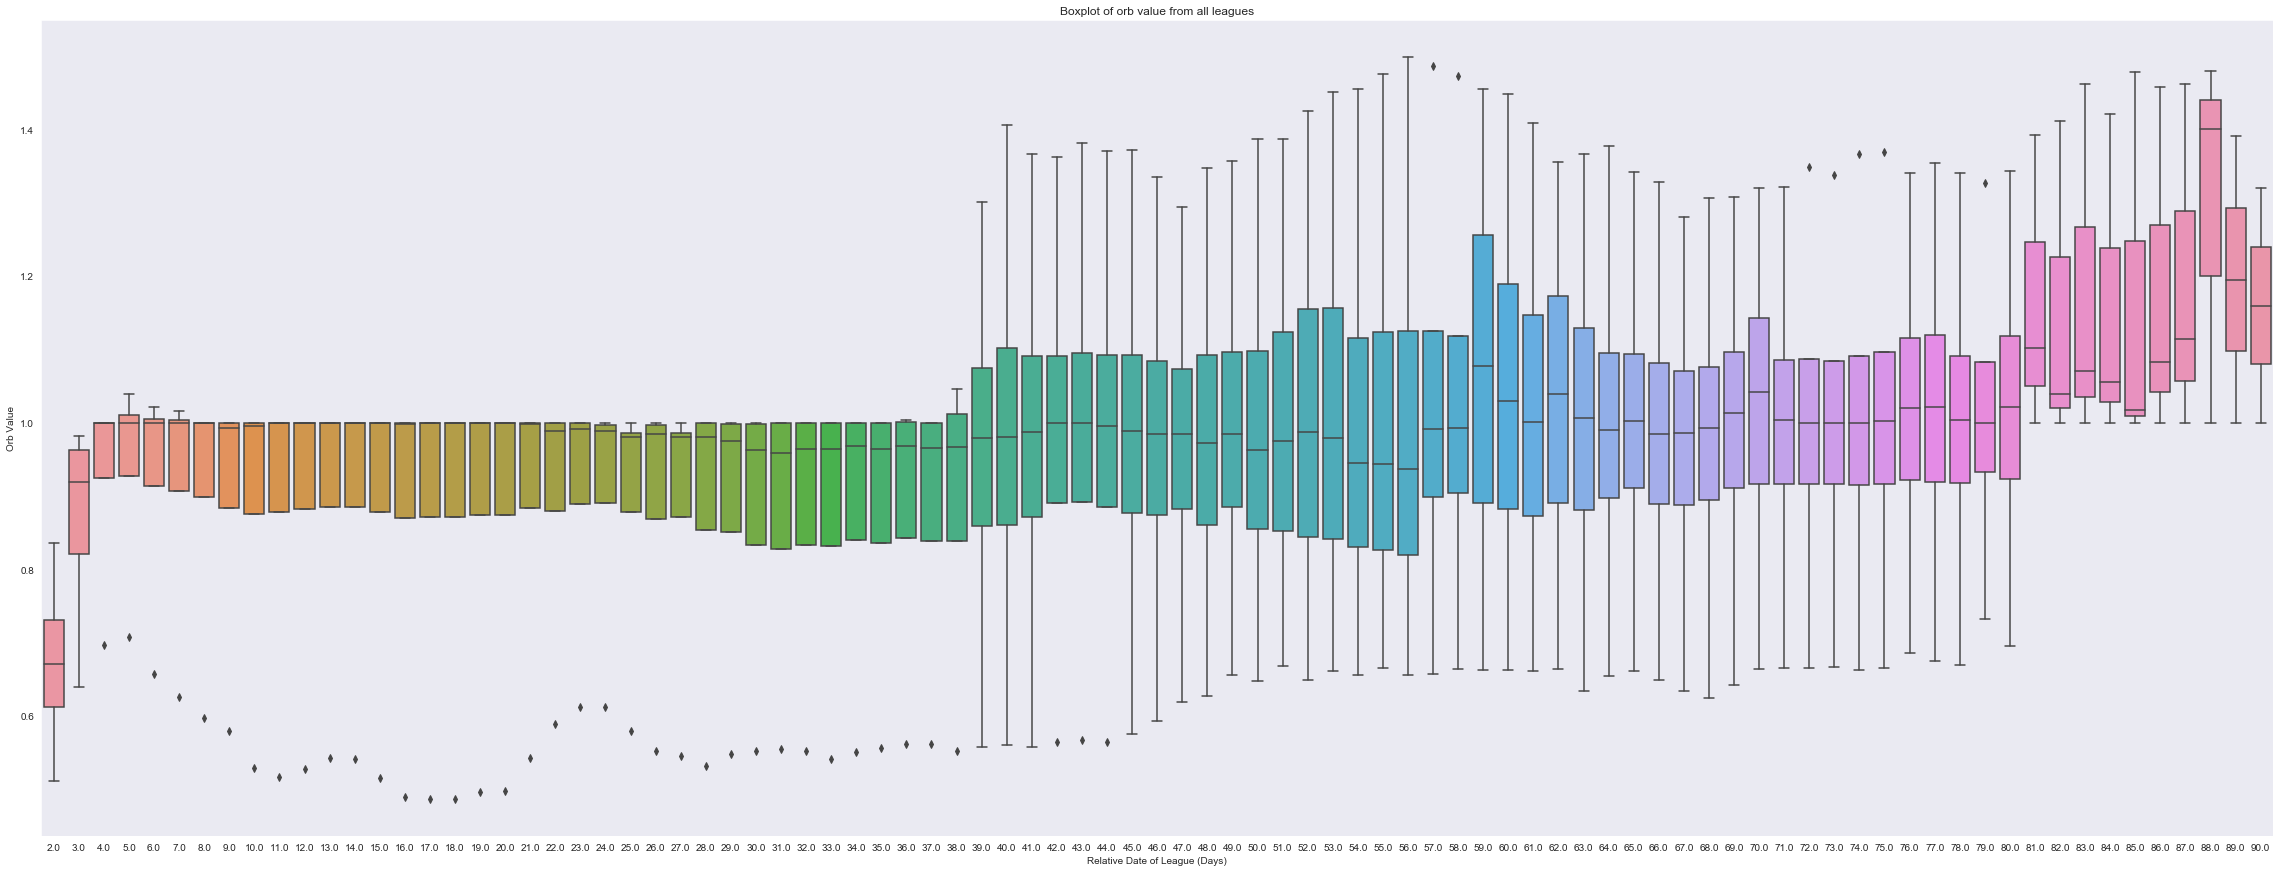

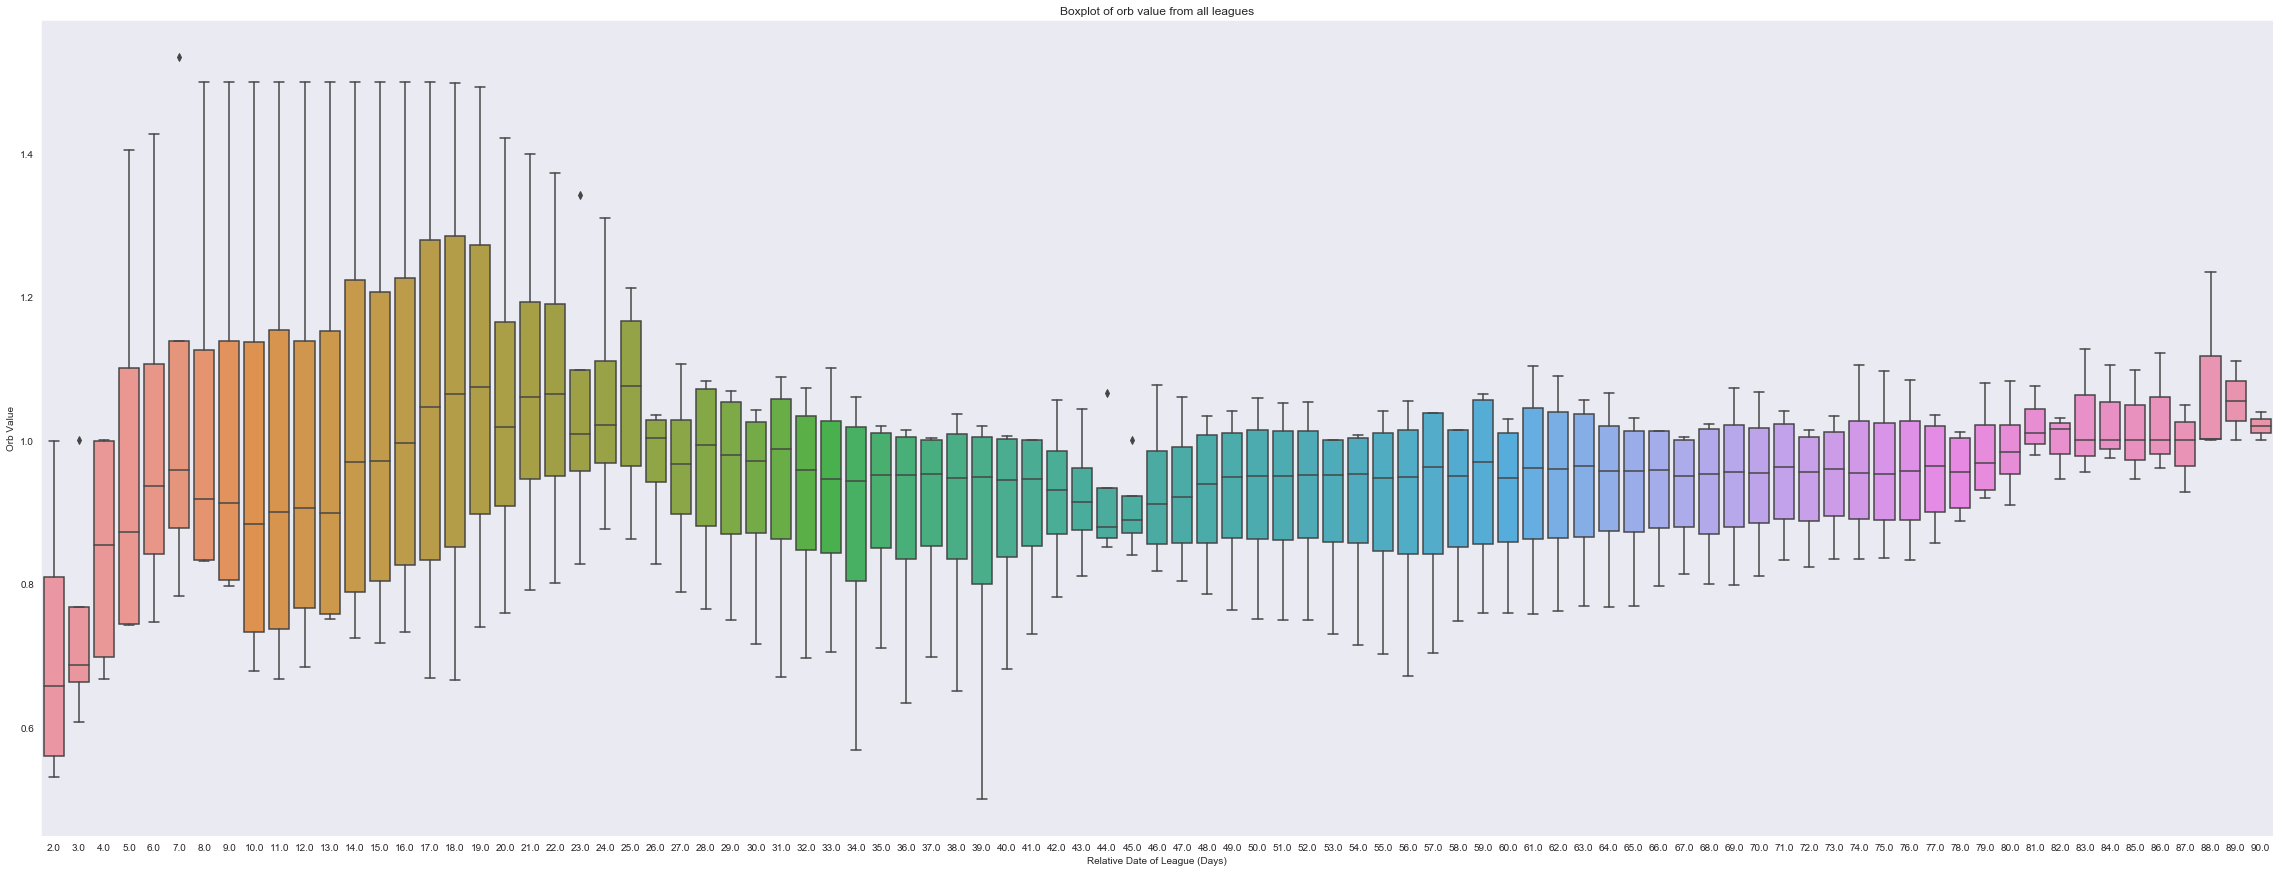

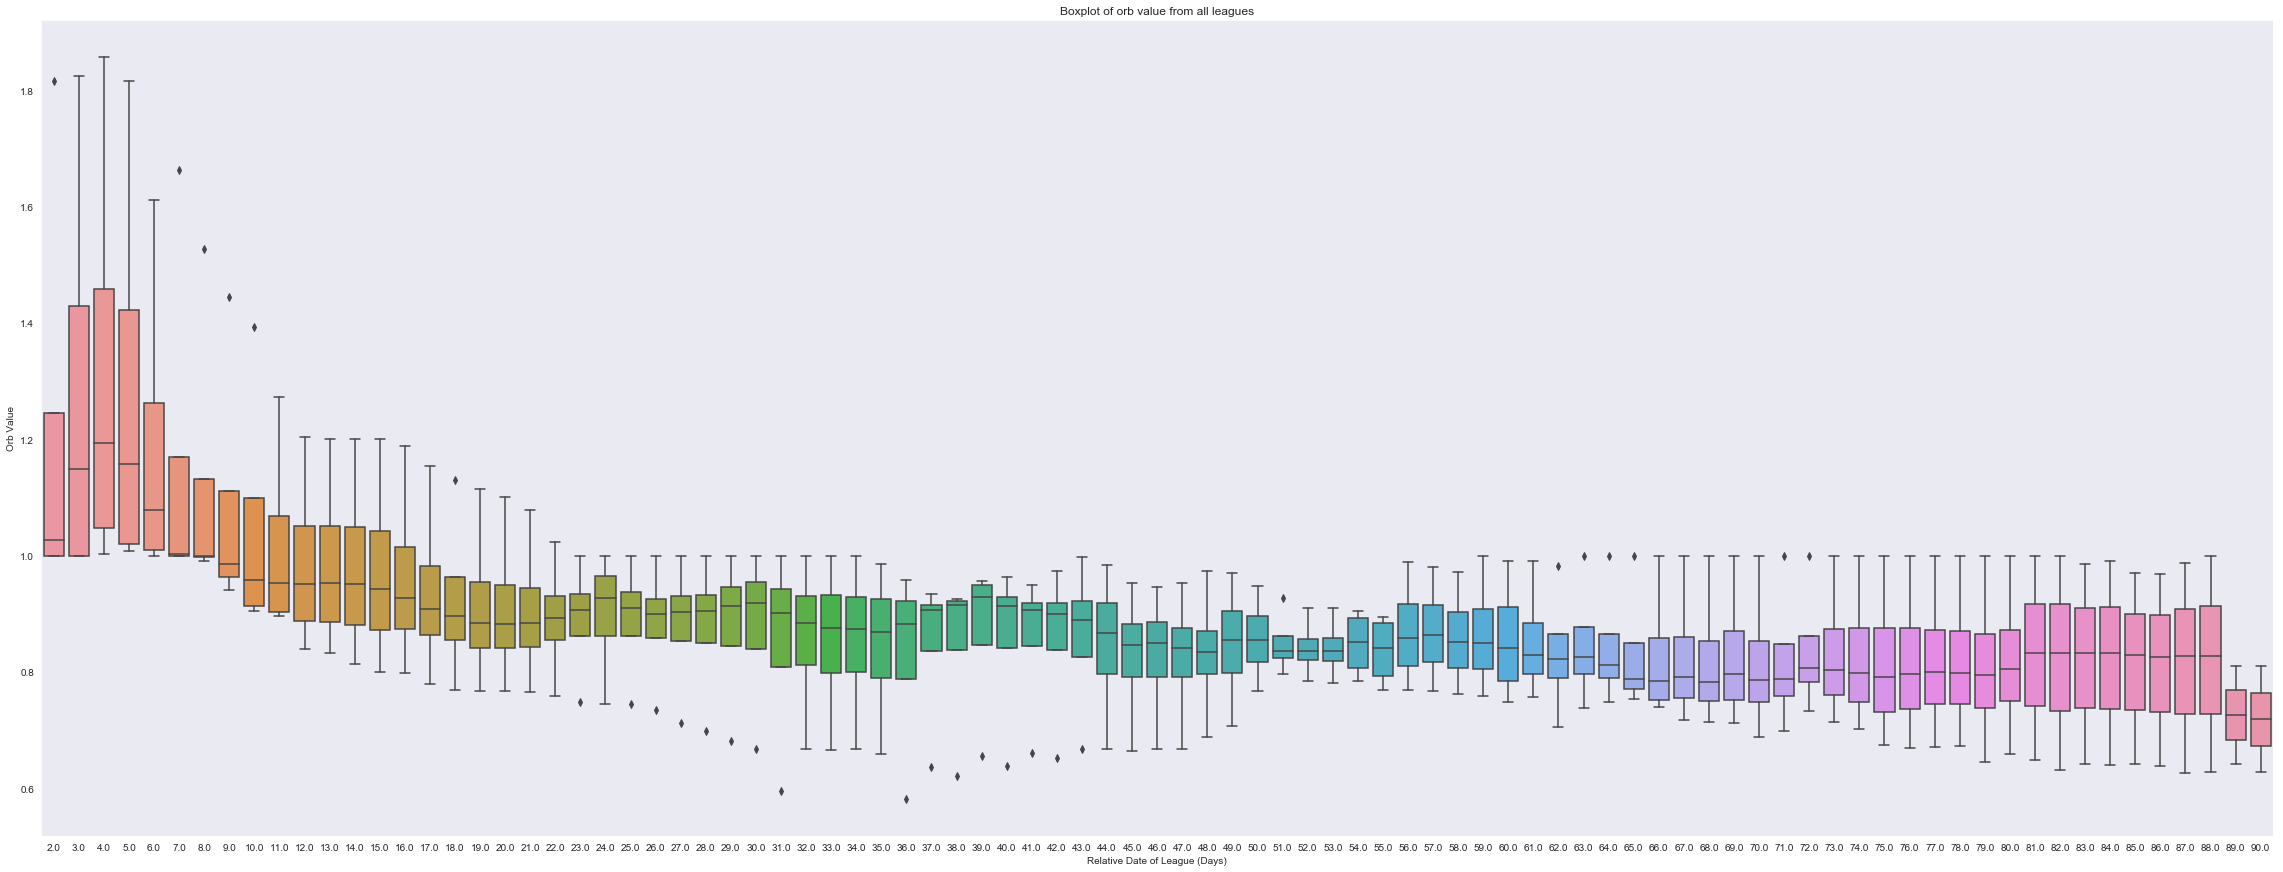

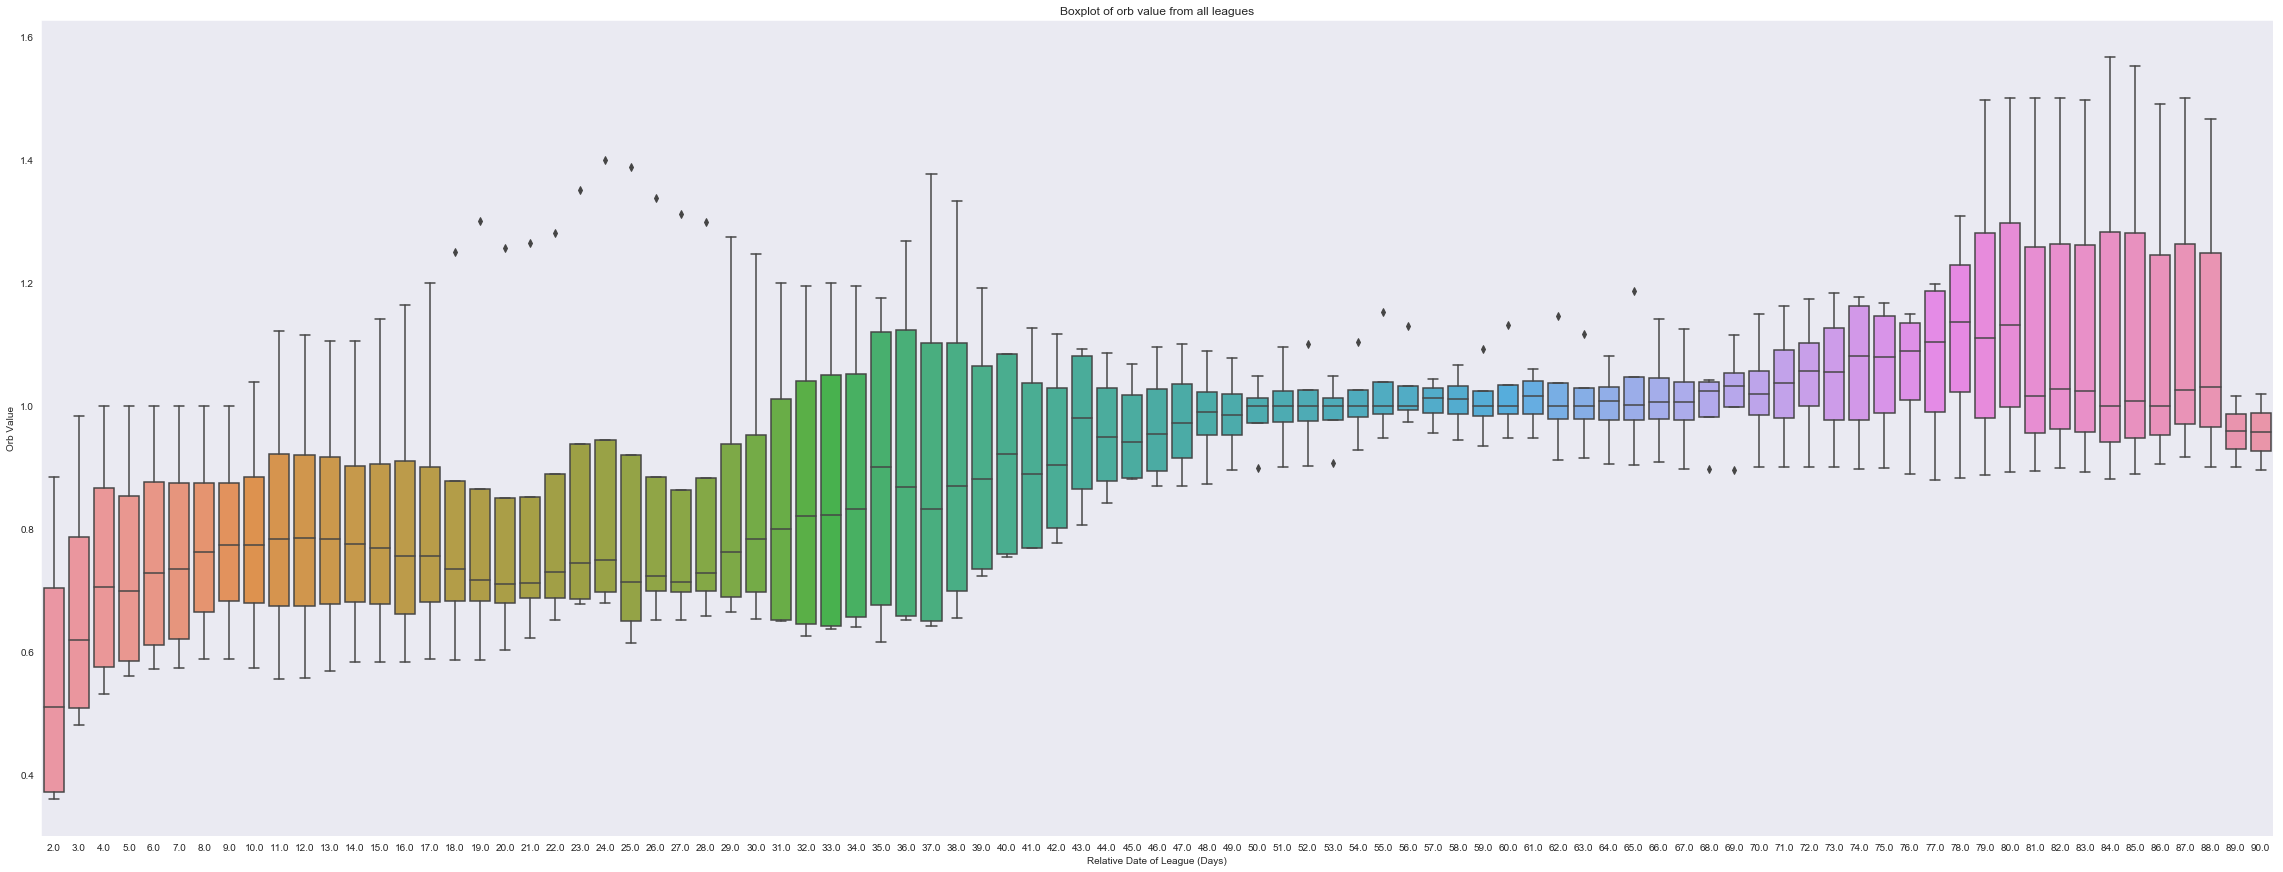

In [367]:
for orb in major_orbs:
    chaos_orb_df = currency_df_pared[(currency_df_pared["Get"] == orb) & (currency_df_pared["Pay"] == "Chaos Orb")]
    plt.figure(figsize = (40,15))
    ax = sns.boxplot(x = "RelativeDateInt", y = "Value", data = chaos_orb_df)
    ax.set(xlabel = "Relative Date of League (Days)", ylabel = "Orb Value", title = "Boxplot of orb value from all leagues")

### By Specific Orbs

#### Examining exalt to chaos ratios

In [352]:
chaos_exalt_df = currency_df_pared[(currency_df_pared["Get"] == "Exalted Orb") & (currency_df_pared["Pay"] == "Chaos Orb")]

[Text(0,0.5,'Value (Chaos)'),
 Text(0.5,0,'Relative Date of League (Days)'),
 Text(0.5,1,'Value of Exalts in Chaos')]

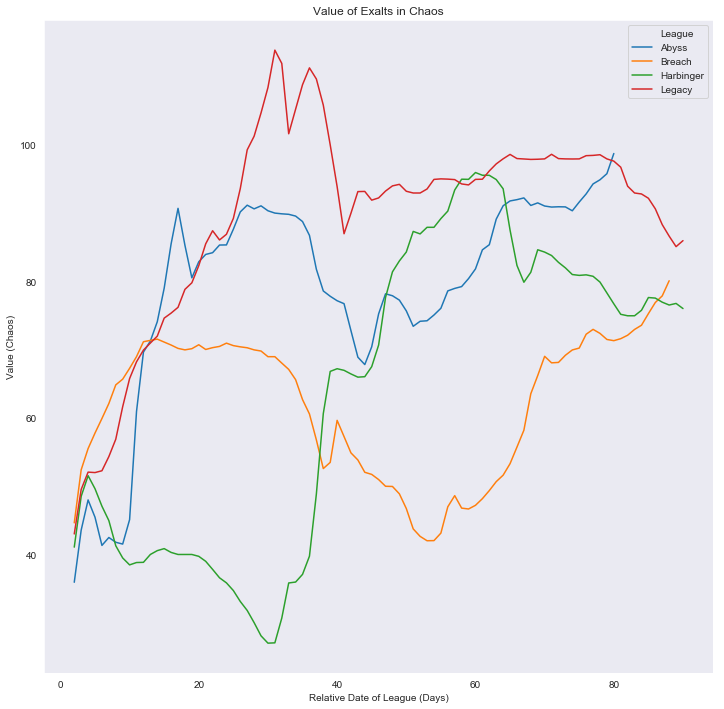

In [353]:
plt.figure(figsize = (12, 12))
ax = sns.lineplot(x = "RelativeDateInt", y = "Value", hue = "League", data = chaos_exalt_df, hue_order = league_name_list)
ax.set(xlabel = "Relative Date of League (Days)", ylabel = "Value (Chaos)", title = "Value of Exalts in Chaos")

[Text(0,0.5,'Value (Exalts)'),
 Text(0.5,0,'Relative Date of League (Days)'),
 Text(0.5,1,'Value of Chaos in Exalts')]

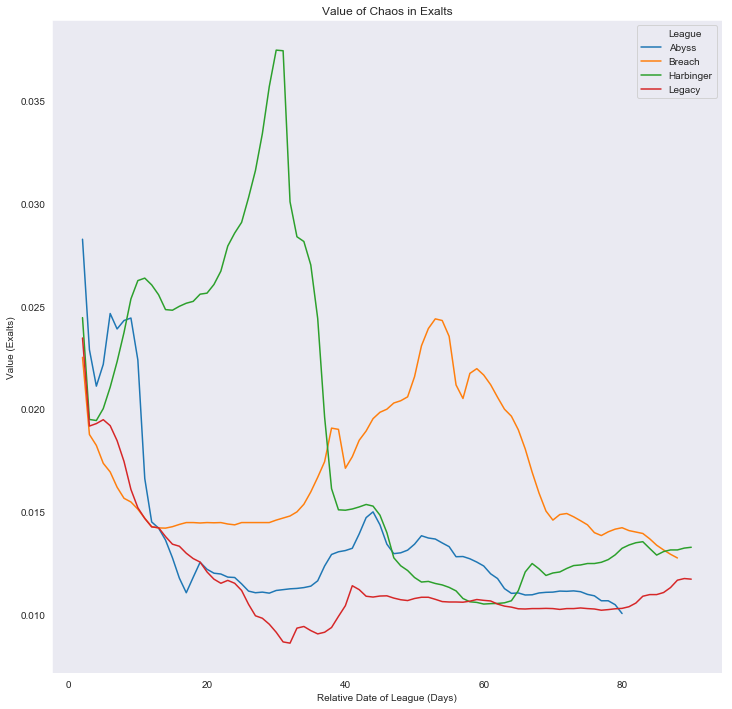

In [354]:
exalt_chaos_df = currency_df_pared[(currency_df_pared["Get"] == "Chaos Orb") & (currency_df_pared["Pay"] == "Exalted Orb")]
plt.figure(figsize = (12, 12))
ax = sns.lineplot(x = "RelativeDateInt", y = "Value", hue = "League", data = exalt_chaos_df, hue_order = league_name_list)
ax.set(xlabel = "Relative Date of League (Days)", ylabel = "Value (Exalts)", title = "Value of Chaos in Exalts")

In [355]:
c_e_abyss_df = chaos_exalt_df[chaos_exalt_df["League"] == "Abyss"].reset_index(drop = True)
e_c_abyss_df = exalt_chaos_df[exalt_chaos_df["League"] == "Abyss"].reset_index(drop = True)

[Text(0,0.5,'Value (Exalts)')]

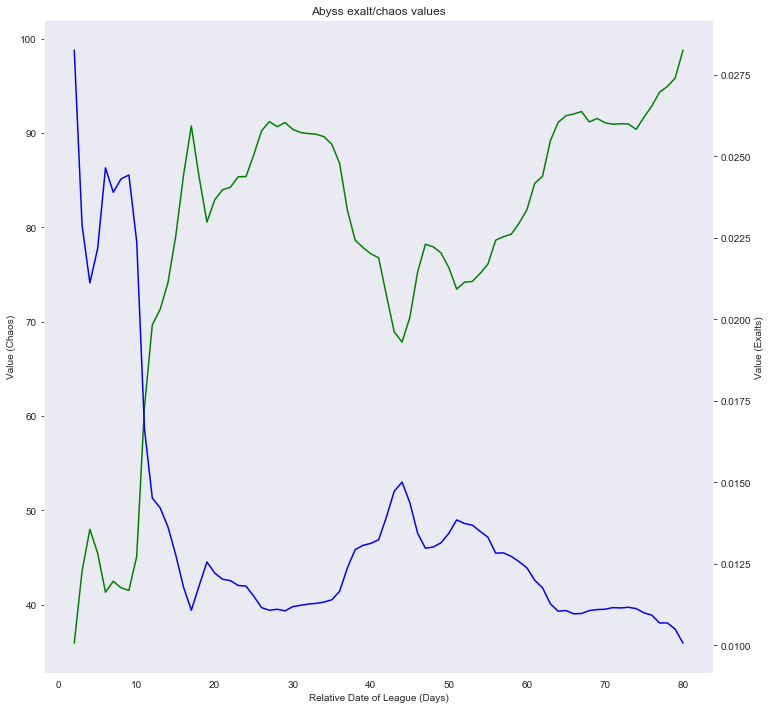

In [356]:
plt.figure(figsize = (12, 12))
ax = sns.lineplot(x = "RelativeDateInt", y = "Value", data = c_e_abyss_df, color = "g")
ax.set(xlabel = "Relative Date of League (Days)", ylabel = "Value (Chaos)", title = "Abyss exalt/chaos values")
ax2 = ax.twinx()
ax = sns.lineplot(x = "RelativeDateInt", y = "Value", data = e_c_abyss_df, color = "b")
ax2.set(ylabel = "Value (Exalts)")

In [357]:
e_c_conversion = pd.DataFrame()
e_c_conversion["Value"] = e_c_abyss_df.Value.multiply(c_e_abyss_df.Value)
e_c_conversion["RelativeDateInt"] = e_c_abyss_df["RelativeDateInt"]
e_c_conversion.head()

Value  RelativeDateInt
0  1.015256              2.0
1  0.997407              3.0
2  1.013696              4.0
3  1.008268              5.0
4  1.018739              6.0

[Text(0,0.5,'Value Ratio'),
 Text(0.5,0,'Relative Date of League (Days)'),
 Text(0.5,1,'Ratio of exalt value to chaos value')]

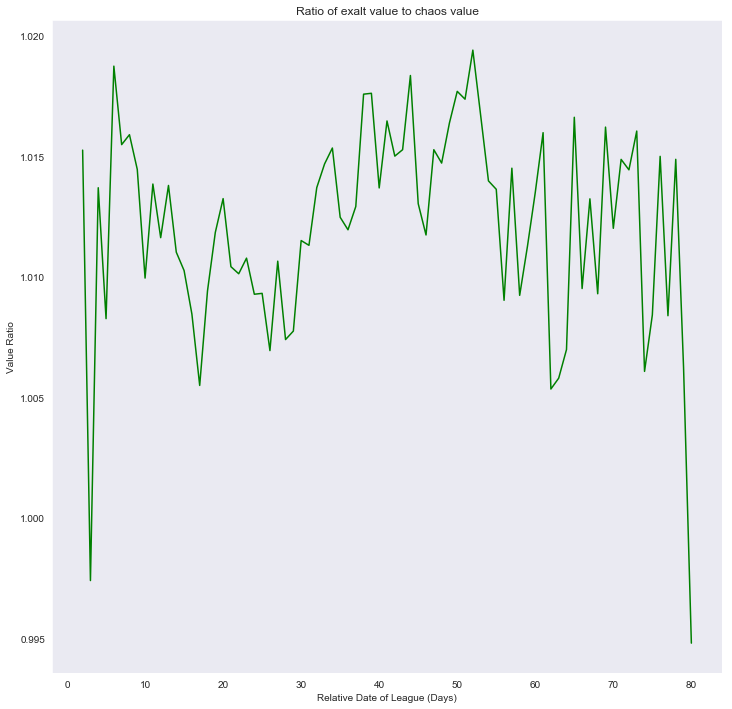

In [358]:
plt.figure(figsize = (12, 12))
ax = sns.lineplot(x = "RelativeDateInt", y = "Value", data = e_c_conversion, color = "g")
ax.set(xlabel = "Relative Date of League (Days)", ylabel = "Value Ratio", title = "Ratio of exalt value to chaos value")

In [359]:
e_c_conversion["Rolling Mean Value"] = e_c_conversion.Value.rolling(4, min_periods=1).mean()

[Text(0,0.5,'Rolling Mean Value Ratio'),
 Text(0.5,0,'Relative Date of League (Days)'),
 Text(0.5,1,'Rolling mean value ratio of exalt value to chaos value')]

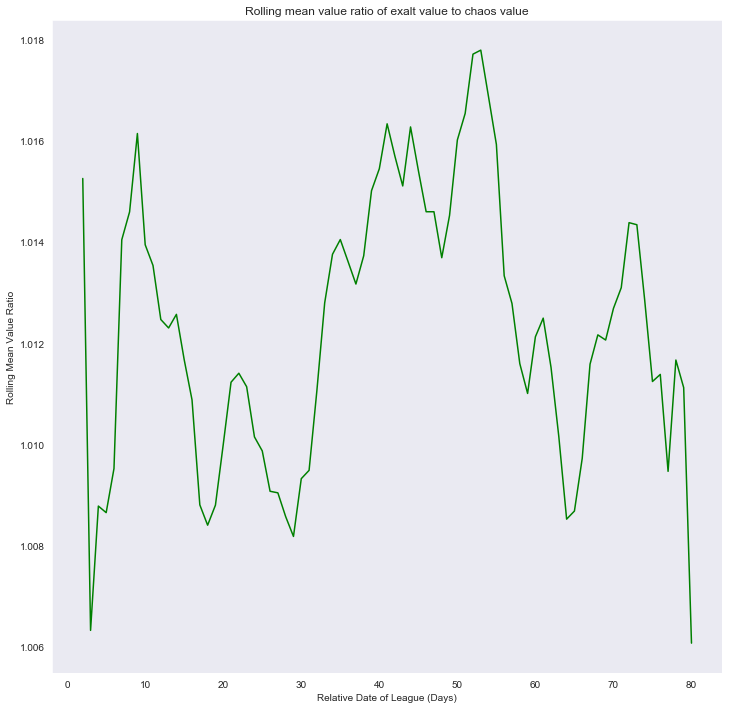

In [360]:
plt.figure(figsize = (12, 12))
ax = sns.lineplot(x = "RelativeDateInt", y = "Rolling Mean Value", data = e_c_conversion, color = "g")
ax.set(xlabel = "Relative Date of League (Days)", ylabel = "Rolling Mean Value Ratio", title = "Rolling mean value ratio of exalt value to chaos value")

#### Let's generalize this for all leagues in our dataframe

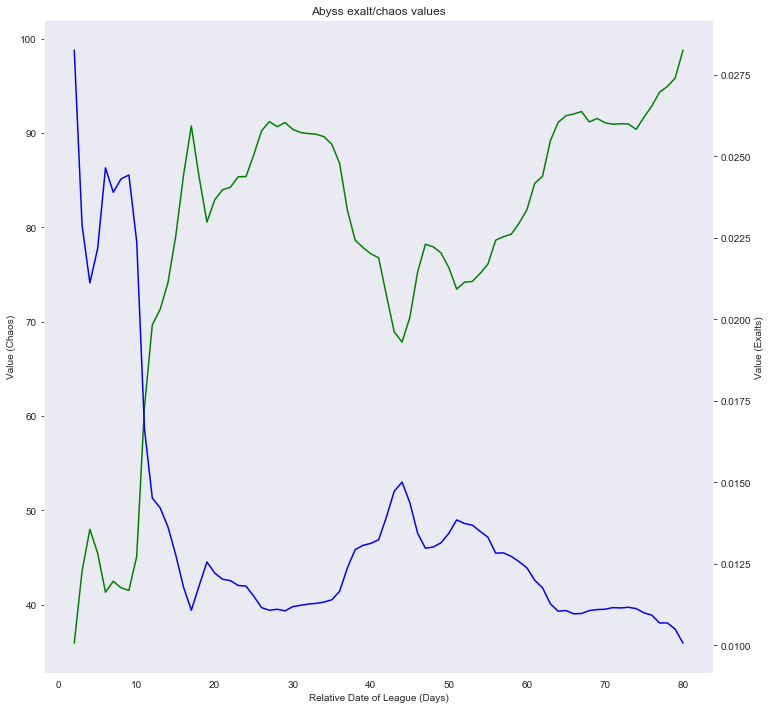

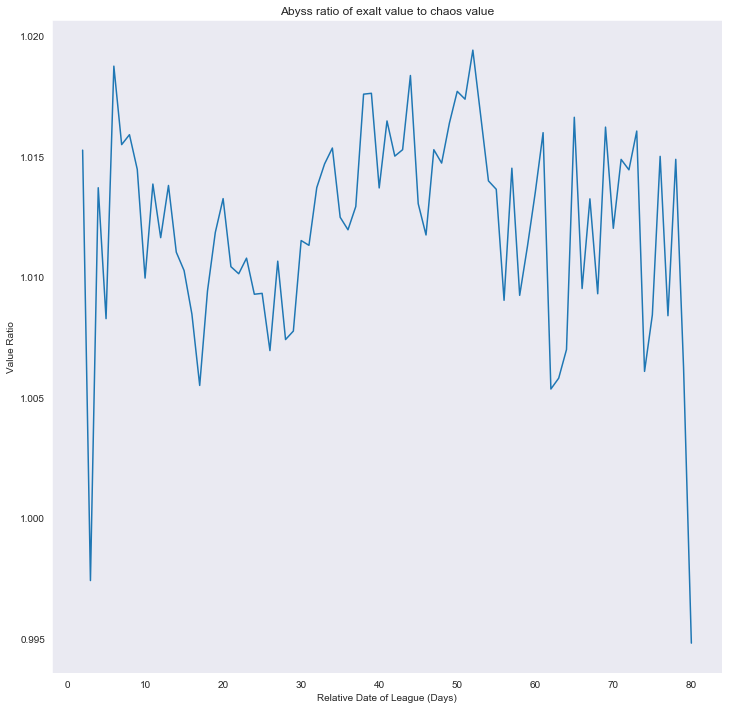

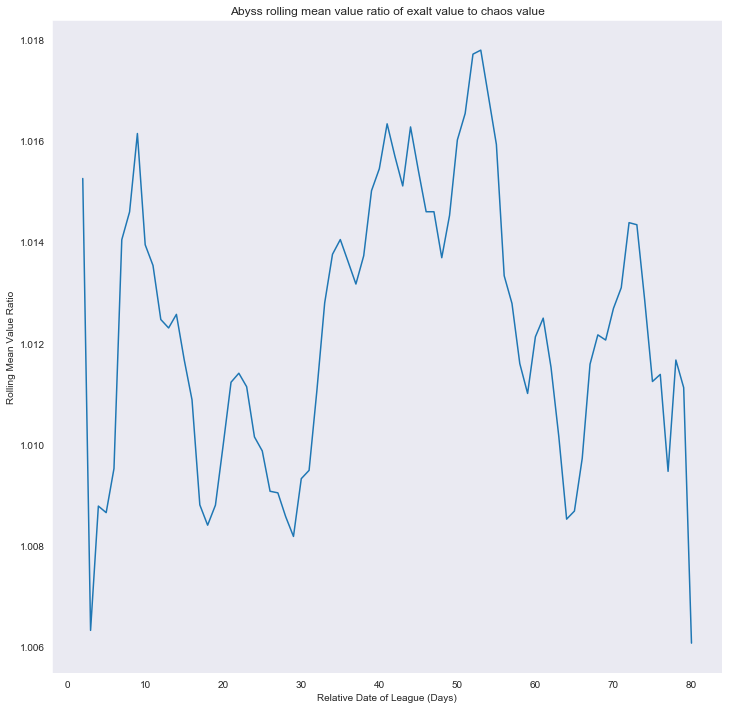

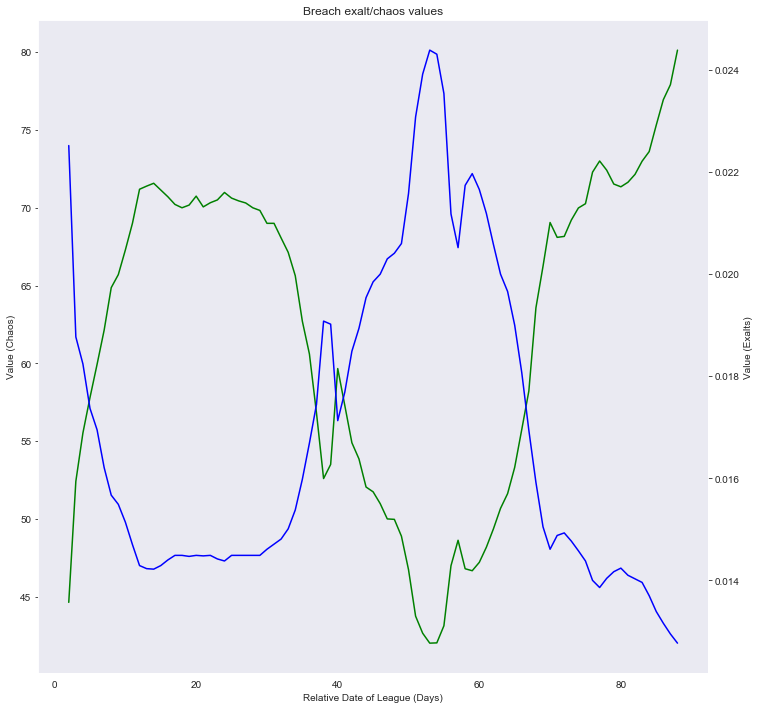

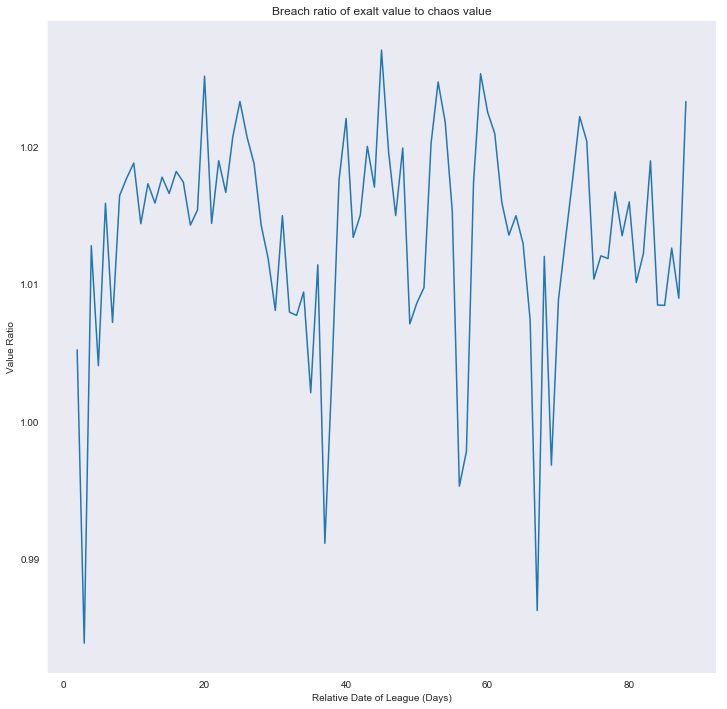

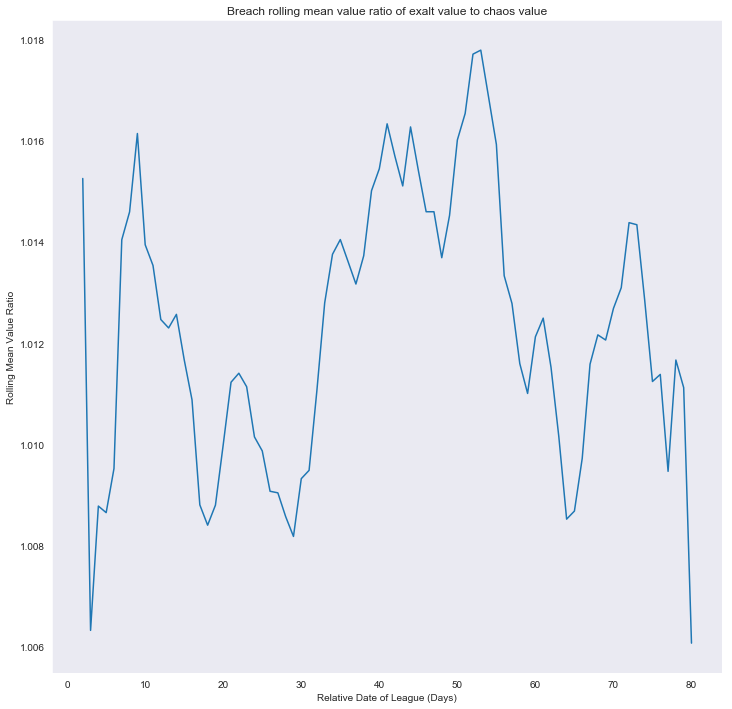

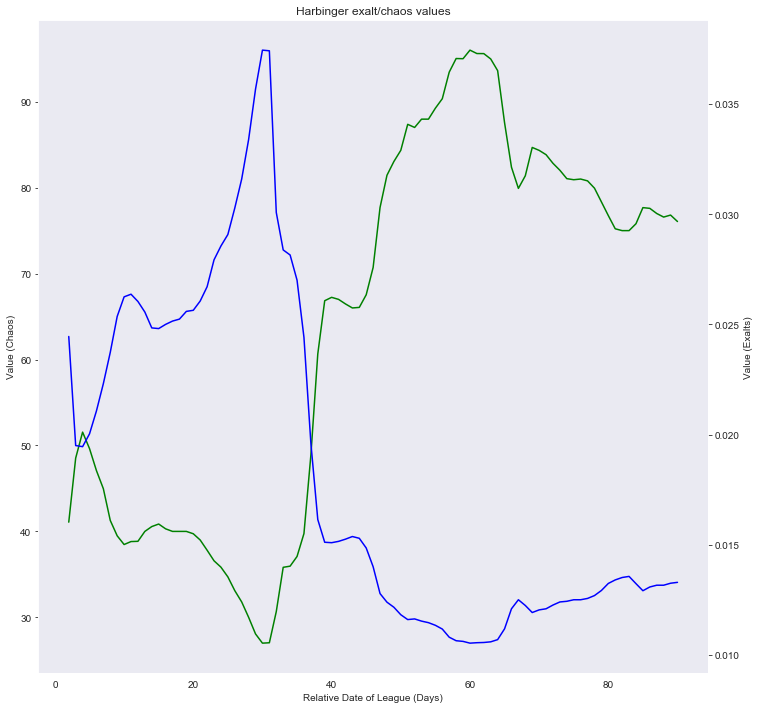

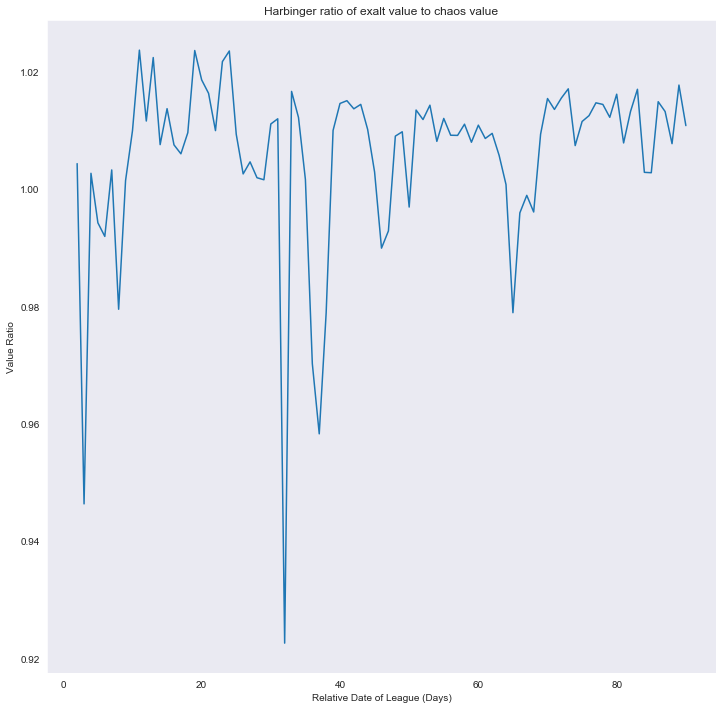

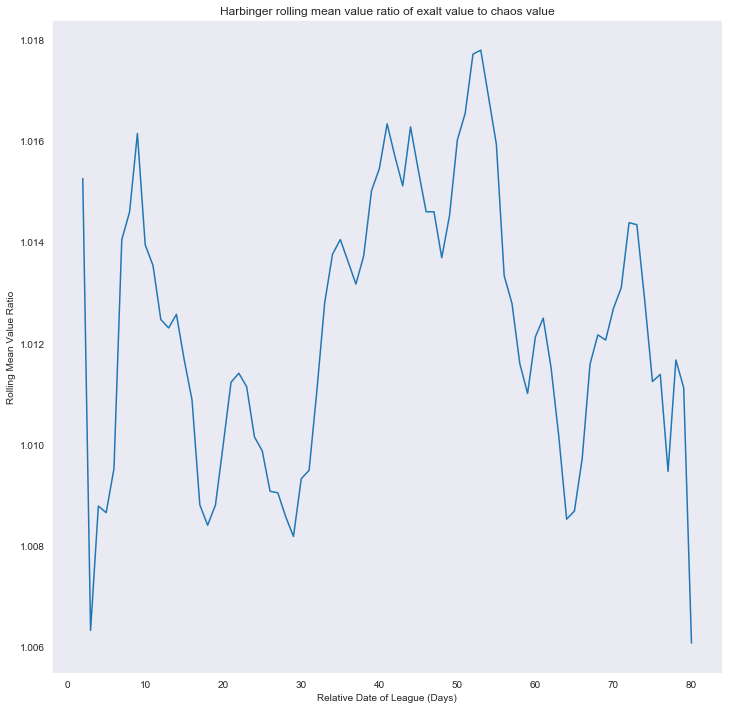

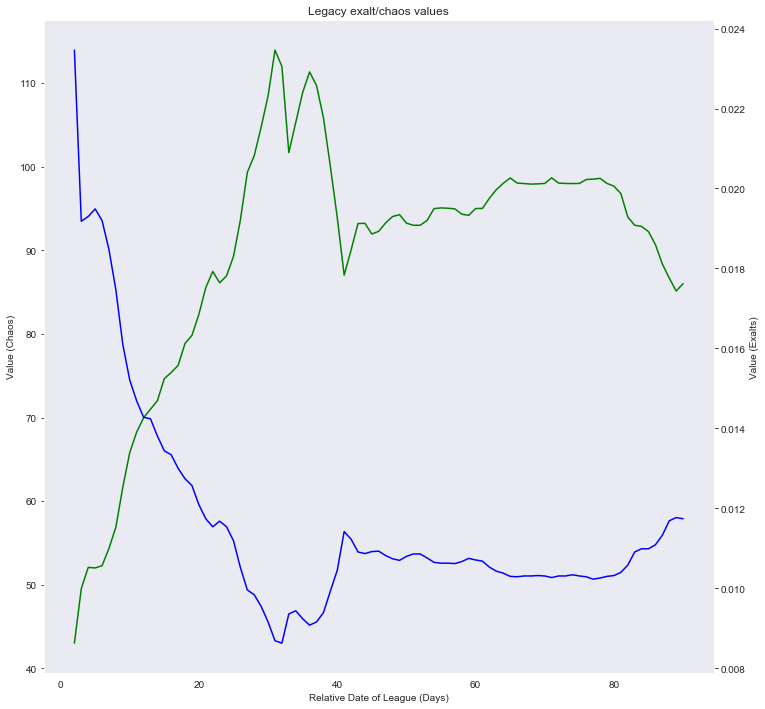

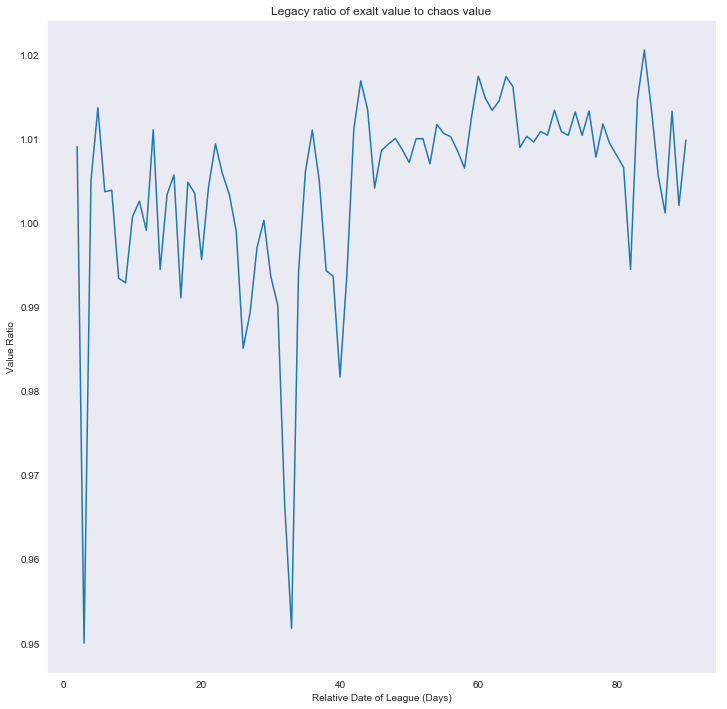

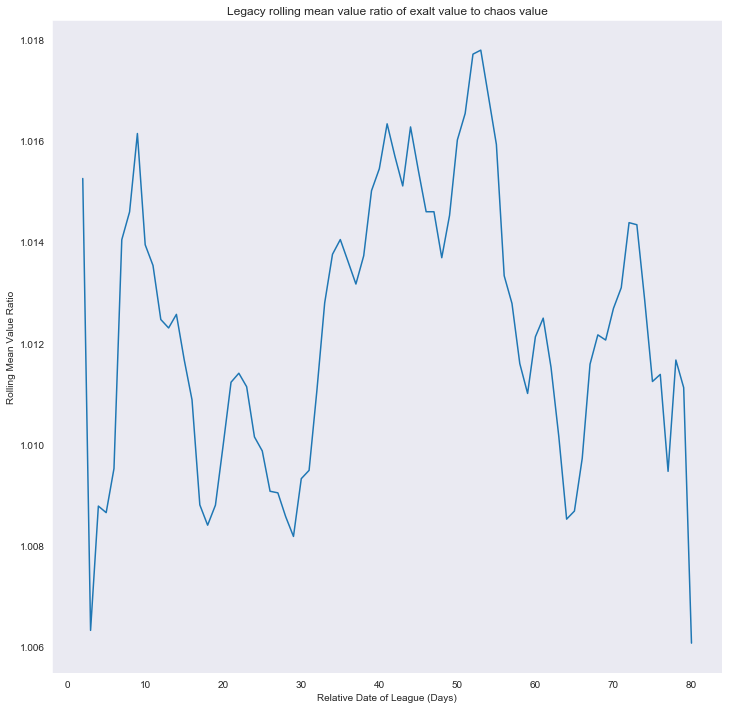

In [361]:
e_c_rolling_means = []
for league in league_name_list:
    c_e_league_df = chaos_exalt_df[chaos_exalt_df["League"] == league].reset_index(drop = True)
    e_c_league_df = exalt_chaos_df[exalt_chaos_df["League"] == league].reset_index(drop = True)
    plt.figure(figsize = (12, 12))
    ax = sns.lineplot(x = "RelativeDateInt", y = "Value", data = c_e_league_df, color = "g")
    ax.set(xlabel = "Relative Date of League (Days)", ylabel = "Value (Chaos)", title = league + " exalt/chaos values")
    ax2 = ax.twinx()
    ax = sns.lineplot(x = "RelativeDateInt", y = "Value", data = e_c_league_df, color = "b")
    ax2.set(ylabel = "Value (Exalts)")
    fig.tight_layout()
    e_c_league_conversion = pd.DataFrame()
    e_c_league_conversion["Value"] = e_c_league_df.Value.multiply(c_e_league_df.Value)
    e_c_league_conversion["RelativeDateInt"] = e_c_league_df["RelativeDateInt"]
    plt.figure(figsize = (12, 12))
    ax = sns.lineplot(x = "RelativeDateInt", y = "Value", data = e_c_league_conversion)
    ax.set(xlabel = "Relative Date of League (Days)", ylabel = "Value Ratio", title = league + " ratio of exalt value to chaos value")
    e_c_league_conversion["Rolling Mean Value"] = e_c_league_conversion.Value.rolling(4, min_periods = 1).mean()
    e_c_rolling_means.append(e_c_league_conversion)
    plt.figure(figsize = (12, 12))
    ax = sns.lineplot(x = "RelativeDateInt", y = "Rolling Mean Value", data = e_c_conversion)
    ax.set(xlabel = "Relative Date of League (Days)", ylabel = "Rolling Mean Value Ratio", title = league + " rolling mean value ratio of exalt value to chaos value")

In [362]:
e_c_rolling_means_concat = pd.concat(e_c_rolling_means, axis = 0)

[Text(0,0.5,'Rolling Mean Value of Exalt/Chaos Ratio'),
 Text(0.5,0,'Relative Date of League (Days)'),
 Text(0.5,1,'Boxplot of Rolling Mean Value Exalt/Chaos Ratio from All Leagues')]

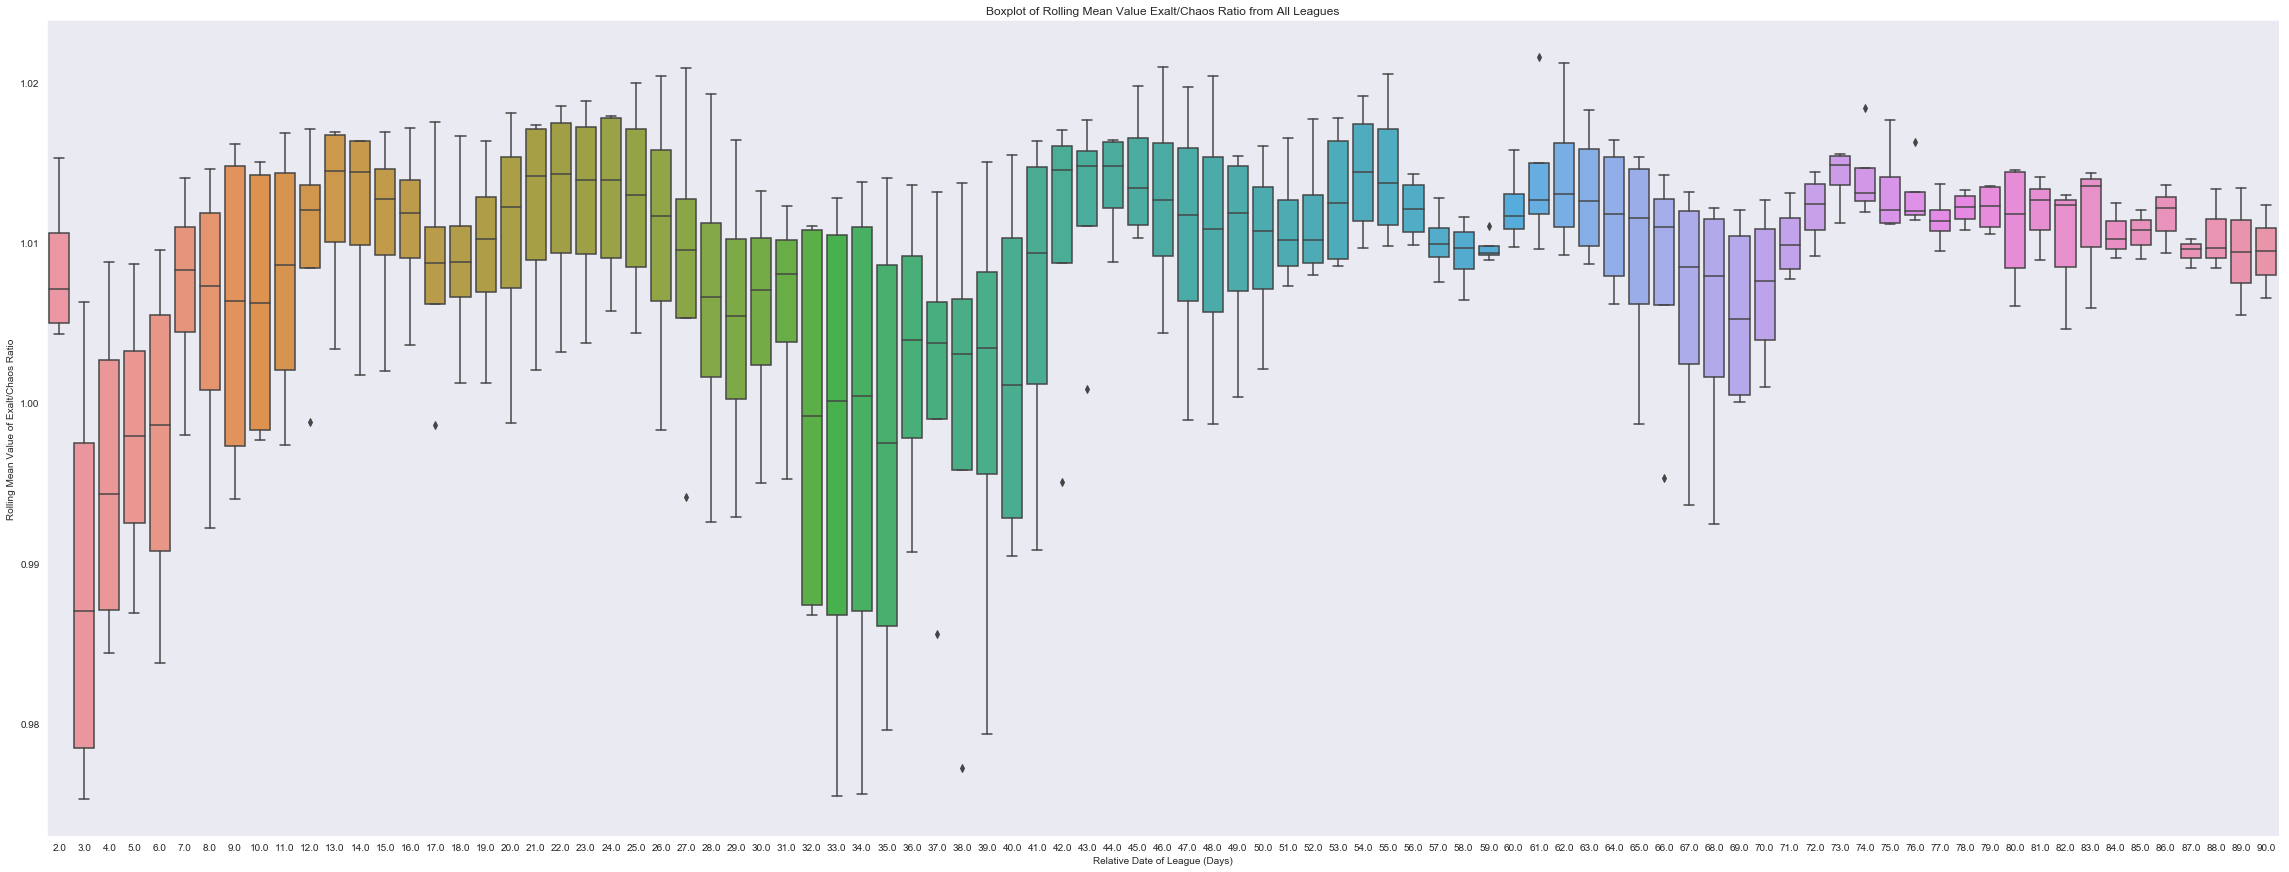

In [363]:
plt.figure(figsize = (40,15))
ax = sns.boxplot(x = "RelativeDateInt", y = "Rolling Mean Value", data = e_c_rolling_means_concat)
ax.set(xlabel = "Relative Date of League (Days)", ylabel = "Rolling Mean Value of Exalt/Chaos Ratio", title = "Boxplot of Rolling Mean Value Exalt/Chaos Ratio from All Leagues")